# Imports básicos para todas as análises

In [28]:
import  warnings,                   \
        json,                       \
        pandas as pd,               \
        numpy as np,                \
        plotly.graph_objects as go, \
        mlforecast as mlf,          \
        optuna as opt

from datetime import datetime

from functools import partial

from plotly.subplots import make_subplots

# Modelos-base
from lightgbm import LGBMRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Meta-learner
from sklearn.linear_model import ElasticNet

# A ser usado apenas para a análise de imputação de dados (ao invés de sempre aplicar o valor médio)
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sktime.split import temporal_train_test_split
from sktime.param_est.seasonality import SeasonalityACF
from sktime.param_est.stationarity import StationarityADF
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteError

# Desativar as mensagens de 'warning' que ficam poluindo o output de alguns trechos de código.
warnings.filterwarnings("ignore")

# Para com a verborragia do log do Optuna
opt.logging.set_verbosity(opt.logging.WARNING)

# Wraper pra usar a engine do Plotly ao invocar a função "[DataFrame|Series].plot" do Pandas
pd.options.plotting.backend = "plotly"

# Métricas utilizadas
mape = MeanAbsolutePercentageError(symmetric=False) # Melhor valor possível é 0.0
rmse = MeanSquaredError(square_root=True) # Quanto menor, melhor
mae = MeanAbsoluteError() # Quanto menor, melhor

SALVAR_PLOTS = True
SEED = 42

# Utilidades

In [29]:
def decomp_series(
        df : pd.DataFrame,
        tendencia : bool,
        sazonalidade : bool,
        residuo : bool,
        salvar : bool = False
    ) -> None:
    # A decomposição das séries temporais ajuda a detectar padrões (tendência, sazonalidade)
    #   e identificar outras informações que podem ajudar na interpretação do que está acontecendo.

    cols = df.drop(columns=['ds', 'unique_id']).columns.to_list()
    for c in cols:
        # Utilizei modelo do tipo "add" (aditivo) pois tem séries com valores 0 (zero).
        # Período de 365 dias porque o que me interessa é capturar padrões anuais.
        decomp = seasonal_decompose(df[c], period=365, model="add")
        
        fig_decomp = make_subplots(specs=[[{"secondary_y": True}]])

        fig_decomp.add_trace(
            go.Scatter(
                x=df.ds,
                y=decomp.observed,
                name='observado',
                mode='lines',
                showlegend=True
            ),
            secondary_y=False
        )

        if tendencia:
            fig_decomp.add_trace(
                go.Scatter(
                    x=df.ds,
                    y=decomp.trend,
                    name='tendência',
                    mode='lines',
                    showlegend=True
                ),
                secondary_y=True
            )
        
        if sazonalidade:
            fig_decomp.add_trace(
                go.Scatter(
                    x=df.ds,
                    y=decomp.seasonal,
                    name='sazonalidade',
                    mode='lines',
                    showlegend=True
                ),
                secondary_y=True
            )
        
        if residuo:
            fig_decomp.add_trace(
                go.Scatter(
                    x=df.ds,
                    y=decomp.resid,
                    name='resíduo',
                    mode='lines',
                    showlegend=True
                ),
                secondary_y=False
            )

        fig_decomp.update_yaxes(
            title=dict(text="observado/resíduo", font=dict(family="system-ui", size=18)),
            secondary_y=False,
            zerolinecolor='black',
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            # gridcolor='lightgrey'
        )

        fig_decomp.update_yaxes(
            title=dict(text="tendência/sazonalidade", font=dict(family="system-ui", size=18)),
            secondary_y=True,
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            # gridcolor='lightgrey'
        )

        fig_decomp.update_xaxes(
            title=dict(text="Período", font=dict(family="system-ui", size=18)),
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            # gridcolor='lightgrey'
        )

        # fig_decomp.update_traces(hovertemplate=None)

        fig_decomp.update_layout(
            width=1500,
            height=700,
            plot_bgcolor='#c8d4e3',
            hovermode='x unified',
            title=dict(text="Decomposição da série temporal: {col}".format(col=c), font=dict(family="system-ui", size=24))
        )
        
        if salvar:
            fig_decomp.write_image("./resultados/trecho_alto/aed/decomposicao_serie_{}.png".format(c))
        else:
            fig_decomp.show()
# ============================================================================================ #
def estacionariedade(
        df : pd.DataFrame,
        sp : int
    ) -> None:
    # Avaliar a estacionariedade de cada uma das séries e a sazonalidade (se houver)
    # Existindo sazonalidade, qual a lag (ou quais lags) se encaixam nesta sazonalidade

    cols = df.drop(columns=['ds', 'unique_id']).columns.to_list()
    for c in cols:
        ts = df[c]
        sty_est = StationarityADF()
        sty_est.fit(ts)
        print(c, sty_est.get_fitted_params()["stationary"])

        # Este teste de sazonalidade deve ser aplicado a séries estacionárias.
        # Se precisar tornar uma série em estacionária, tem de aplicar diferenciação antes.
        if sty_est.get_fitted_params()["stationary"]:
            sp_est = SeasonalityACF(candidate_sp=sp, nlags=len(df[c])) # Minha intenção é ter certeza de que existe sazonalidade anual (365 dias)
            sp_est.fit(ts)
            sp_est.get_fitted_params()
            print(c, sp_est.get_fitted_params()["sp_significant"])
# ============================================================================================ #
def mapa_correlacao(
        df : pd.DataFrame,
        medida : str = 'dtw',
        salvar : bool = False
    ) -> None:

    if medida == 'dtw':
        from dtaidistance import dtw

        dtw_dist = dtw.distance_matrix_fast(df.drop(columns=['ds', 'unique_id']).T.values)
        df_dtw_dist = pd.DataFrame(
            data=dtw_dist,
            index=df.drop(columns=['ds', 'unique_id']).columns.to_list(),
            columns=df.drop(columns=['ds', 'unique_id']).columns.to_list(),
        )

        fig = go.Figure()

        fig.add_trace(
            go.Heatmap(
                x=df_dtw_dist.columns,
                y=df_dtw_dist.columns,
                z=df_dtw_dist,
                text=df_dtw_dist.values,
                texttemplate = "%{text:.7f}",
                textfont = {"size": 14},
                colorscale="rainbow",
                hovertemplate = "%{y}<br>%{x}</br><extra></extra>"
            )
        )

        fig.update_yaxes(
            tickfont=dict(
                family="system-ui",
                size=14
            ),
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
        )

        fig.update_xaxes(
            tickfont=dict(
                family="system-ui",
                size=14
            ),
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
        )

        fig.update_layout(
            width=1500,
            height=700, 
            title=dict(
                text="Mapa de correlação (DTW)",
                font=dict(
                    family="system-ui",
                    size=24
                )
            )
        )
    
    elif medida == 'pearson':

        corr = df.drop(columns=['ds', 'unique_id']).corr()

        fig = go.Figure()
        
        fig.add_trace(
            go.Heatmap(
                x=corr.columns,
                y=corr.columns,
                z=corr,
                text=corr.values,
                texttemplate = "%{text:.7f}",
                textfont = {"size": 14},
                colorscale="rainbow",
                hovertemplate = "%{y}<br>%{x}</br><extra></extra>"
            )
        )
        
        fig.update_yaxes(
            tickfont=dict(
                family="system-ui",
                size=14
            ),
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
        )
        
        fig.update_xaxes(
            tickfont=dict(
                family="system-ui",
                size=14
            ),
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
        )
        
        fig.update_layout(
            width=1500,
            height=700, 
            title=dict(
                text="Mapa de correlação (coeficiente de Pearson)",
                font=dict(
                    family="system-ui",
                    size=24
                )
            )
        )
    
    else:
        raise Exception("Opção errada. ('dtw' ou 'pearson')")



    if salvar:
        fig.write_image("./resultados/trecho_alto/aed/mapa_correlacao_{medida}.png".format(medida=medida))
    else:
        fig.show()
# ============================================================================================ #
def plot_linha_tabela(
        df_merged : pd.DataFrame,
        regressor : str,
        plot_title : str,
        line_color : str,
        short_name : str,
        salvar : bool = False
    ) -> None:

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[[{"type": "scatter"}], [{"type": "table"}]]
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged.ds,
            y=df_merged.y,
            mode='lines',
            name='observado',
            line=dict(color="#000000", width=4)
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged.ds,
            y=df_merged[regressor],
            mode='lines',
            name=short_name,
            line=dict(color=line_color)
        ),
        row=1, col=1
    )

    fig.append_trace(
        go.Table(
            header=dict(values=["sMAPE", "RMSE", "MAE"], font=dict(size=14), align="left"),
            cells=dict(values=[
                mape(df_merged.y, df_merged[regressor]),
                rmse(df_merged.y, df_merged[regressor]),
                mae(df_merged.y, df_merged[regressor])
            ],
            font=dict(size=12),
            height=24,
            align="left")
        ),
        row=2, col=1
    )

    fig.update_yaxes(
        title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)),
        zerolinecolor='black',
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        # gridcolor='lightgrey'
    )
    
    fig.update_xaxes(
        title=dict(text="Período", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        # gridcolor='lightgrey'
    )

    fig.update_layout(
        width=1500,
        height=1000,
        hovermode='x unified',
        plot_bgcolor='#c8d4e3',
        title=dict(text=plot_title, font=dict(family="system-ui", size=24))
    )

    if salvar:
        now = datetime.now()
        fig.write_image("./testes/{reg}_{dt}.png".format(reg=regressor, dt=now.strftime("%Y-%m-%d_%H-%M-%S")))
    else:
        fig.show()
# ============================================================================================ #
def cria_plot_correlacao(
        serie : pd.Series,
        n_lags : int,
        plot_pacf : bool = False,
        salvar : bool = False
    ) -> None:

    corr_array = pacf(serie.dropna(), nlags=n_lags, alpha=0.05) if plot_pacf else acf(serie.dropna(), nlags=n_lags, alpha=0.05)
    lower_y = corr_array[1][:, 0] - corr_array[0]
    upper_y = corr_array[1][:, 1] - corr_array[0]

    fig = go.Figure()
    
    # Desenha as linhas verticais pretas
    [fig.add_scatter(
            x=(x, x),
            y=(0, corr_array[0][x]),
            mode='lines',
            line_color='black',
            hovertemplate = "<extra></extra>"
        ) for x in range(len(corr_array[0]))
    ]
    
    # Desenha as bolinhas vermelhas
    fig.add_scatter(
        x=np.arange(len(corr_array[0])),
        y=corr_array[0],
        mode='markers',
        marker_color='red',
        marker_size=12,
        hovertemplate = "x = %{x}<br>y = %{y}<extra></extra>"
    )
    
    # Desenha a 'nuvem' clarinha acima do eixo x
    fig.add_scatter(
        x=np.arange(len(corr_array[0])),
        y=upper_y,
        mode='lines',
        line_color='rgba(255,255,255,0)',
        hovertemplate = "<extra></extra>"
    )

    # Desenha a 'nuvem' clarinha abaixo do eixo x
    fig.add_scatter(
        x=np.arange(len(corr_array[0])),
        y=lower_y,
        mode='lines',
        fillcolor='rgba(32, 146, 230,0.3)',
        fill='tonexty',
        line_color='rgba(255,255,255,0)',
        hovertemplate = "<extra></extra>"
    )
    
    fig.update_traces(showlegend=False)

    fig.update_xaxes(
        range=[-1, n_lags+1],
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        # gridcolor='lightgrey'
    )
    
    fig.update_yaxes(
        zerolinecolor='black', # Quando 'y=0' a linha é preta
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        # gridcolor='lightgrey'
    )
    
    title = 'Autocorrelação Parcial (PACF) para n_lags={n}'.format(n=n_lags) if plot_pacf else 'Autocorrelação (ACF) para n_lags={n}'.format(n=n_lags)
    fig.update_layout(
        width=1500,
        height=700,
        plot_bgcolor='#c8d4e3',
        title=dict(text=title, font=dict(family="system-ui", size=24))
    )

    if salvar:
        fig.write_image("./resultados/trecho_alto/aed/plot_pacf.png") if plot_pacf else fig.write_image("./resultados/trecho_alto/aed/plot_acf.png")
    else:
        fig.show()
# ============================================================================================ #
def cria_dataframe_futuro(
        df_futr : pd.DataFrame,
        df_train : pd.DataFrame,
        df_test : pd.DataFrame,
        tp_valor : str,
        n_lags : int,
        date_features : list,
        cols : list
    ) -> pd.DataFrame:

    if tp_valor == 'ultimo': # Usa o último valor conhecido
        for c in cols:
            df_futr[c] = df_train[c].iat[-1]

    elif tp_valor == 'media': # Usa o valor médio de cada coluna vazão
        for c in cols:
            df_futr[c] = df_train[c].mean()

    elif tp_valor == 'ml':
        from xgboost import XGBRegressor
        
        for c in cols:
            fcst = mlf.MLForecast(
                models=XGBRegressor(seed=5),
                freq='D',
                lags=[i+1 for i in range(n_lags)],
                date_features=date_features
            )

            df_temp = df_train[['ds', 'unique_id', c]]
            fcst.fit(df_temp, id_col='unique_id', time_col='ds', target_col=c, static_features=[])
            df_preds = fcst.predict(h=len(df_futr)).reset_index() # macetasso pra não dar erro de index
            df_futr[c] = df_preds['XGBRegressor']

    else:
        raise Exception("Opção inválida! (ultimo | media | ml)")
            
    df_futr = pd.merge(
        left=df_futr,
        right=df_test.drop(columns=cols+['y']),
        on=['ds', 'unique_id'],
        how='left'
    )
    
    return df_futr
# ============================================================================================ #
def distribuicao_dados(
        df_original : pd.DataFrame,
        df_media : pd.DataFrame,
        df_knn : pd.DataFrame,
        salvar : bool = False
    ) -> None:

    cols = np.asarray(df_original.drop(columns=['ds', 'unique_id']).columns)

    for c in cols:
        fig = go.Figure()

        fig.add_trace(go.Box(
            y=df_original[c].values,
            name='original',
            marker_color='darkblue',
            jitter=0.5,
            pointpos=-2,
            boxpoints='all',
            boxmean='sd')
        )

        fig.add_trace(go.Box(
            y=df_media[c].values,
            name='média',
            marker_color='coral',
            jitter=0.5,
            pointpos=-2,
            boxpoints='all',
            boxmean='sd')
        )

        fig.add_trace(go.Box(
            y=df_knn[c].values,
            name='kNN',
            marker_color='olive',
            jitter=0.5,
            pointpos=-2,
            boxpoints='all',
            boxmean='sd')
        )

        fig.update_xaxes(
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            # gridcolor='lightgrey'
        )

        fig.update_yaxes(
            zerolinecolor='black',
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            # gridcolor='lightgrey'
        )

        fig.update_layout(
            width=1500,
            height=1000,
            plot_bgcolor='#c8d4e3',
            title=dict(text="Distribuição {c}".format(c=c), font=dict(family="system-ui", size=24))
        )

        if salvar:
            fig.write_image("./resultados/trecho_alto/aed/distribuicao_dados_{}.png".format(c))
        else:
            fig.show()
# ============================================================================================ #
def plot_feature_importance(
        model : str,
        forecaster : mlf.MLForecast,
        fch : str = "",
        salvar : bool = False
    ) -> None:

    if model in ['LinearRegression', 'LinearSVR']:
        fig = go.Figure(data=[go.Bar(x=forecaster.ts.features_order_, y=forecaster.models_[model].coef_, showlegend=False)])
    elif model == "LGBMRegressor":
        fig = go.Figure(data=[go.Bar(x=forecaster.ts.features_order_, y=forecaster.models_[model].feature_importances_, showlegend=False)])
    else:
        raise Exception("Esta opção não existe.")

    fig.update_yaxes(
        title=dict(text="Pesos/Valores", font=dict(family="system-ui", size=18)),
        zerolinecolor='black',
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        # gridcolor='lightgrey',
    )
    
    fig.update_xaxes(
        title=dict(text="Feature", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        # gridcolor='lightgrey',
    )
    
    fig.update_layout(
        width=1500,
        height=700,
        plot_bgcolor='#c8d4e3',
        title=dict(text="Feature importance {m} (fch={fch})".format(m=model, fch=fch), font=dict(family="system-ui", size=24))
    )

    if salvar:
        now = datetime.now()
        fig.write_image("./resultados/trecho_alto/feature_importance/feature_importance_{m}_fch{fch}_{dt}.png".format(m=model,
                                                                                                                      fch=fch,
                                                                                                                      dt=now.strftime("%Y-%m-%d_%H-%M-%S")))
    else:
        fig.show()
# ============================================================================================ #
def exportar_dict_json(
        v_dict : dict,
        pasta : str,
        nome_arq : str
    ) -> None:

    import json

    json_str = json.dumps(v_dict, indent=4)
    with open(pasta+nome_arq, "w") as a:
        a.write(json_str)
# ============================================================================================ #
def plot_divisao_treino_teste(
        df_treino : pd.DataFrame,
        df_teste : pd.DataFrame,
        col_data : str = 'ds',
        col_plot : str = 'y',
        salvar : bool = False
    ) -> None:

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=df_treino[col_data],
            y=df_treino[col_plot],
            mode='lines',
            name='treino'
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df_teste[col_data],
            y=df_teste[col_plot],
            mode='lines',
            name='teste'
        )
    )

    fig.update_yaxes(
        title=dict(
            text="Vazão (m³/s) / Precipitação (mm/dia)",
            font=dict(
                family="system-ui",
                size=18
            )
        ),
        zerolinecolor='black', 
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
    )

    fig.update_xaxes(
        title=dict(
            text="Período",
            font=dict(
                family="system-ui",
                size=18
            )
        ),
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
    )

    fig.update_layout(
        width=1500,
        height=700,
        hovermode="x unified",
        plot_bgcolor='#c8d4e3',
        title=dict(
            text="Vazão 'y' (target)",
            font=dict(
                family="system-ui",
                size=24
            )
        )
    )

    if salvar:
        fig.write_image("./resultados/trecho_alto/aed/divisao_treino_teste_{c}.png".format(c=col_plot))
    else:
        fig.show()
# ============================================================================================ #

# Carregando e imputando dados

In [30]:
df = pd.read_excel('alto_rio_doce_final.xlsx', sheet_name=0, index_col=0, header=0, parse_dates=['Data'])

In [31]:
# Só reordenando a posição das colunas pra ficar mais fácil de ler e entender
df = df[['c_vz_56425000', 't_cv_56425000', 't_cv_56338500', 't_cv_56338080', 't_cv_56110005', 't_cv_56337200', 't_cv_56337500',
        't_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500']]

# Deixando o DataFrame no padrão que a lib MLForecast obriga
df['unique_id'] = 1
df = df.reset_index()
df = df.rename(
    columns={
        'Data' : 'ds',
        'c_vz_56425000' : 'y'
    }
)

df

,ds,y,t_cv_56425000,t_cv_56338500,t_cv_56338080,t_cv_56110005,t_cv_56337200,t_cv_56337500,t_vz_56338500,t_vz_56110005,t_vz_56337200,t_vz_56337500,unique_id
0,2013-01-01,82.787100,NaN,NaN,NaN,0.0,NaN,NaN,NaN,60.056100,NaN,NaN,1
1,2013-01-02,80.489300,NaN,NaN,NaN,0.0,NaN,NaN,NaN,46.950000,NaN,NaN,1
2,2013-01-03,78.214200,NaN,NaN,NaN,0.0,NaN,NaN,NaN,46.703125,NaN,NaN,1
3,2013-01-04,79.348900,NaN,NaN,NaN,0.0,NaN,NaN,NaN,49.239583,NaN,NaN,1
4,2013-01-05,129.161000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,49.780208,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,2023-12-27,88.370937,8.2,0.2,0.0,0.0,2.2,8.6,99.451667,70.568804,0.610000,28.053750,1
4013,2023-12-28,87.519375,2.0,1.2,0.0,0.0,0.0,0.8,93.551667,60.014457,33.753333,21.705417,1
4014,2023-12-29,76.317813,0.0,0.0,0.0,0.0,0.0,0.0,77.745652,49.910909,61.942917,21.022917,1
4015,2023-12-30,67.118542,14.8,3.4,0.0,3.0,4.8,19.8,70.258261,47.746848,58.080000,22.252500,1


In [32]:
# Percentual de dados faltantes, por coluna

print(100*df.drop(columns=['ds', 'unique_id']).isna().sum() / len(df))

y                 0.000000
t_cv_56425000    40.801593
t_cv_56338500    34.478467
t_cv_56338080    38.411750
t_cv_56110005     0.000000
t_cv_56337200    34.478467
t_cv_56337500    34.478467
t_vz_56338500    35.648494
t_vz_56110005     0.074683
t_vz_56337200    35.822753
t_vz_56337500    48.095594
dtype: float64


##### Preenchendo com a média

In [33]:
df_media = df.fillna(df.mean())
df_media

,ds,y,t_cv_56425000,t_cv_56338500,t_cv_56338080,t_cv_56110005,t_cv_56337200,t_cv_56337500,t_vz_56338500,t_vz_56110005,t_vz_56337200,t_vz_56337500,unique_id
0,2013-01-01,82.787100,3.193061,2.621505,0.037914,0.0,2.482675,2.246239,114.113770,60.056100,72.465690,29.862489,1
1,2013-01-02,80.489300,3.193061,2.621505,0.037914,0.0,2.482675,2.246239,114.113770,46.950000,72.465690,29.862489,1
2,2013-01-03,78.214200,3.193061,2.621505,0.037914,0.0,2.482675,2.246239,114.113770,46.703125,72.465690,29.862489,1
3,2013-01-04,79.348900,3.193061,2.621505,0.037914,0.0,2.482675,2.246239,114.113770,49.239583,72.465690,29.862489,1
4,2013-01-05,129.161000,3.193061,2.621505,0.037914,0.0,2.482675,2.246239,114.113770,49.780208,72.465690,29.862489,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,2023-12-27,88.370937,8.200000,0.200000,0.000000,0.0,2.200000,8.600000,99.451667,70.568804,0.610000,28.053750,1
4013,2023-12-28,87.519375,2.000000,1.200000,0.000000,0.0,0.000000,0.800000,93.551667,60.014457,33.753333,21.705417,1
4014,2023-12-29,76.317813,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,77.745652,49.910909,61.942917,21.022917,1
4015,2023-12-30,67.118542,14.800000,3.400000,0.000000,3.0,4.800000,19.800000,70.258261,47.746848,58.080000,22.252500,1


##### Preenchendo com o KNNImputer

In [34]:
# Recomendam aplicar um scaling antes de imputar com o KNNImputer, mas nos testes que realizei deu nenhuma diferença nos resultados
# Então vou reduzir a engenharia de programação e não usar scaling

imputer = KNNImputer(
    n_neighbors=7,
    weights='distance'
)

df_knn = pd.DataFrame(
    imputer.fit_transform(
        df.drop(columns=['ds', 'unique_id'])
    ),
    columns=df.drop(columns=['ds', 'unique_id']).columns
)

df_knn = pd.DataFrame(
    data=df_knn,
    columns=df.drop(columns=['ds', 'unique_id']).columns
)
df_knn = pd.concat([df[['ds', 'unique_id']], df_knn], axis=1)
df_knn

,ds,unique_id,y,t_cv_56425000,t_cv_56338500,t_cv_56338080,t_cv_56110005,t_cv_56337200,t_cv_56337500,t_vz_56338500,t_vz_56110005,t_vz_56337200,t_vz_56337500
0,2013-01-01,1,82.787100,0.241148,0.202105,0.0,0.0,0.437702,0.551181,79.298366,60.056100,49.154342,29.104130
1,2013-01-02,1,80.489300,0.174561,0.024937,0.0,0.0,0.168651,0.000000,80.660440,46.950000,34.521715,41.121955
2,2013-01-03,1,78.214200,0.588994,0.848283,0.0,0.0,0.322936,0.566388,82.201442,46.703125,38.586211,51.963603
3,2013-01-04,1,79.348900,0.317681,0.425111,0.0,0.0,0.093011,0.288712,76.099995,49.239583,48.206779,17.611111
4,2013-01-05,1,129.161000,2.034343,0.869555,0.0,0.0,1.522630,1.933175,108.219680,49.780208,63.708133,22.068745
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,2023-12-27,1,88.370937,8.200000,0.200000,0.0,0.0,2.200000,8.600000,99.451667,70.568804,0.610000,28.053750
4013,2023-12-28,1,87.519375,2.000000,1.200000,0.0,0.0,0.000000,0.800000,93.551667,60.014457,33.753333,21.705417
4014,2023-12-29,1,76.317813,0.000000,0.000000,0.0,0.0,0.000000,0.000000,77.745652,49.910909,61.942917,21.022917
4015,2023-12-30,1,67.118542,14.800000,3.400000,0.0,3.0,4.800000,19.800000,70.258261,47.746848,58.080000,22.252500


In [35]:
# Quantos '0' existem nas colunas de vazão
# O percentual, no caso

cols = [
    't_vz_56338500',
    't_vz_56110005',
    't_vz_56337200',
    't_vz_56337500'
]

for c in cols:
    print(100 * (df_knn[c] == 0).sum() / len(df_knn))

# Eu pensei que tivesse mais zero. Essa quantidade, para as colunas de vazão, até que tá ok.

0.0
0.0
0.024894199651481205
5.17799352750809


##### Distribuição comparada

In [36]:
distribuicao_dados(
    df_original=df,
    df_media=df_media,
    df_knn=df_knn,
    salvar=SALVAR_PLOTS
)

In [37]:
# Essa coluna tá ruim demais, vou retirar.
# Maioria dos valores está 'colada' no 0.
df_knn = df_knn.drop(columns=['t_cv_56338080'])

##### Separando dados para 'X' e 'y'

Não sei se vai ser necessário usá-los, mas já deixo aqui pra caso precise

In [38]:
df_knn.columns

Index(['ds', 'unique_id', 'y', 't_cv_56425000', 't_cv_56338500',
       't_cv_56110005', 't_cv_56337200', 't_cv_56337500', 't_vz_56338500',
       't_vz_56110005', 't_vz_56337200', 't_vz_56337500'],
      dtype='object')

In [39]:
df_X = df_knn.drop(columns=['y'], axis=1)
df_y = df_knn[['ds', 'y', 'unique_id']]

In [40]:
# df_X

In [41]:
# df_y

# Análise exploratória dos dados

### Decomposição das Séries Temporais

A decomposição das séries temporais ajuda a detectar padrões (tendência, sazonalidade) e identificar outras informações que podem ajudar na interpretação do que está acontecendo.

Executei a tarefa no atributo "df" pois isso me garante que estou tratando dos dados originais, sem alteração nenhuma, vindos do arquivo CSV.

In [42]:
decomp_series(
    df=df_knn,
    tendencia=True,
    sazonalidade=False,
    residuo=False,
    salvar=SALVAR_PLOTS
)

### Estacionariedade

In [43]:
estacionariedade(
    df=df_knn,
    sp=365
)

y True
y [365]
t_cv_56425000 True
t_cv_56425000 [365]
t_cv_56338500 True
t_cv_56338500 [365]
t_cv_56110005 True
t_cv_56110005 [365]
t_cv_56337200 True
t_cv_56337200 [365]
t_cv_56337500 True
t_cv_56337500 [365]
t_vz_56338500 True
t_vz_56338500 [365]
t_vz_56110005 True
t_vz_56110005 [365]
t_vz_56337200 True
t_vz_56337200 [365]
t_vz_56337500 True
t_vz_56337500 []


A série 't_vz_56337500' é estacionária, contudo, na lag 365 ela não apresenta sazonalidade.

### Correlação entre as séries

In [44]:
mapa_correlacao(
    df=df_knn,
    medida='dtw',
    salvar=False, #SALVAR_PLOTS
)

In [45]:
# Usando o sweetviz para avaliar
# import sweetviz as sv
# analyze_report = sv.analyze(df_knn)
# analyze_report.show_html('analyze.html', open_browser=True)

# Apresentando os resultados (serve apenas para usar no Google Colab)
# import IPython
# IPython.display.HTML('analyze.html')

In [46]:
# Preferi jogar os dados alterados para um novo DataFrame porque se precisar voltar no DataFrame inicial, não precisará regarregar o arquivo
df_aux = df_knn.copy()

In [47]:
df_aux.drop(columns=['ds', 'unique_id']).describe()

,y,t_cv_56425000,t_cv_56338500,t_cv_56110005,t_cv_56337200,t_cv_56337500,t_vz_56338500,t_vz_56110005,t_vz_56337200,t_vz_56337500
count,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000
mean,118.023065,2.991348,2.596121,2.870451,2.303570,1.996776,103.375251,68.911155,66.202400,26.261579
std,120.338238,8.676786,8.403539,9.691323,7.527579,6.136959,112.261359,64.780970,61.985264,35.889518
min,21.358300,0.000000,0.000000,0.000000,0.000000,0.000000,21.195000,9.619672,0.000000,0.000000
25%,58.098100,0.000000,0.000000,0.000000,0.000000,0.000000,50.425000,31.555208,29.016667,4.688275
50%,82.441400,0.017697,0.000000,0.000000,0.000000,0.000000,78.962500,50.025937,51.087384,12.270833
75%,133.011000,1.239609,1.074228,0.200000,0.822984,0.600000,115.950208,77.045208,82.987500,31.631458
max,2000.470000,172.400000,181.200000,197.000000,110.900000,97.400000,1936.280000,819.429375,928.774167,258.637500


In [48]:
mapa_correlacao(
    df=df_aux,
    salvar=False, #SALVAR_PLOTS
)

### Análise de Autocorrelação

In [49]:
# Me interessa saber a sazonalidade da variável-alvo, a vazão
cria_plot_correlacao(
    serie=df_aux.y,
    n_lags=500,
    plot_pacf=False,
    salvar=False #SALVAR_PLOTS
)

# Na lag 365 o gráfico volta a descer.
# Isso nos dá uma visão da sazonalidade da série, que é de 365 dias

In [50]:
# vazoes = ['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500']
# chuvas = ['t_cv_56425000', 't_cv_56338500', 't_cv_56110005', 't_cv_56337200', 't_cv_56337500']
cria_plot_correlacao(
    serie=df_aux['y'],
    n_lags=15,
    plot_pacf=True,
    salvar=False #SALVAR_PLOTS
)

# Dá pra ver que depois de 2 lags, ocorre um drop no gráfico.
# Isso nos dá um indício de quantas lags usar em "look_back".
# Se fosse um modelo tipo ARIMA a ser utilizado, ele seria AR(2)

### Relação entre as variáveis

In [51]:
salvar = SALVAR_PLOTS

vazoes = [
    't_vz_56338500',
    't_vz_56110005',
    't_vz_56337200',
    't_vz_56337500'
]
for v in vazoes:
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=df_aux[v],
            y=df_aux['y'],
            mode='markers',
            line=dict(color="blue"),
            hovertemplate="eixo_x: %{x}<br>eixo_y: %{y}</br><extra></extra>",
            showlegend=False
        )
    )

    fig.update_xaxes(
        title=dict(text=df_aux[v].name, font=dict(family="system-ui", size=18)),
        zerolinecolor='black',
        showspikes=True,
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        #gridcolor='lightgrey'
    )
    
    fig.update_yaxes(
        title=dict(text=df_aux['y'].name, font=dict(family="system-ui", size=18)),
        zerolinecolor='black',
        showspikes=True,
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        #gridcolor='lightgrey'
    )

    fig.update_layout(
        width=1500,
        height=700,
        hovermode='closest',
        plot_bgcolor='#c8d4e3',
        title=dict(text="Relação entre as variáveis 'y' e '{v}'".format(v=v), font=dict(family="system-ui", size=24))
    )

    if salvar:
        fig.write_image("./resultados/trecho_alto/aed/relacao_y_{v}.png".format(v=v))
    else:
        fig.show()

# ============================================================================ #

chuvas = [
    't_cv_56425000',
    't_cv_56338500',
    't_cv_56110005',
    't_cv_56337200',
    't_cv_56337500'
]
for c in chuvas:
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=df_aux[c],
            y=df_aux['y'],
            mode='markers',
            line=dict(color="green"),
            hovertemplate="eixo_x: %{x}<br>eixo_y: %{y}</br><extra></extra>",
            showlegend=False
        )
    )

    fig.update_yaxes(
        title=dict(text=df_aux['y'].name, font=dict(family="system-ui", size=18)),
        zerolinecolor='black',
        showspikes=True,
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        #gridcolor='lightgrey'
    )
    
    fig.update_xaxes(
        title=dict(text=df_aux[c].name, font=dict(family="system-ui", size=18)),
        zerolinecolor='black',
        showspikes=True,
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        #gridcolor='lightgrey'
    )

    fig.update_layout(
        width=1500,
        height=700,
        hovermode='closest',
        plot_bgcolor='#c8d4e3',
        title=dict(text="Relação entre as variáveis 'y' e '{c}'".format(c=c), font=dict(family="system-ui", size=24))
    )

    if salvar:
        fig.write_image("./resultados/trecho_alto/aed/relacao_y_{c}.png".format(c=c))
    else:
        fig.show()

### Análise de delay

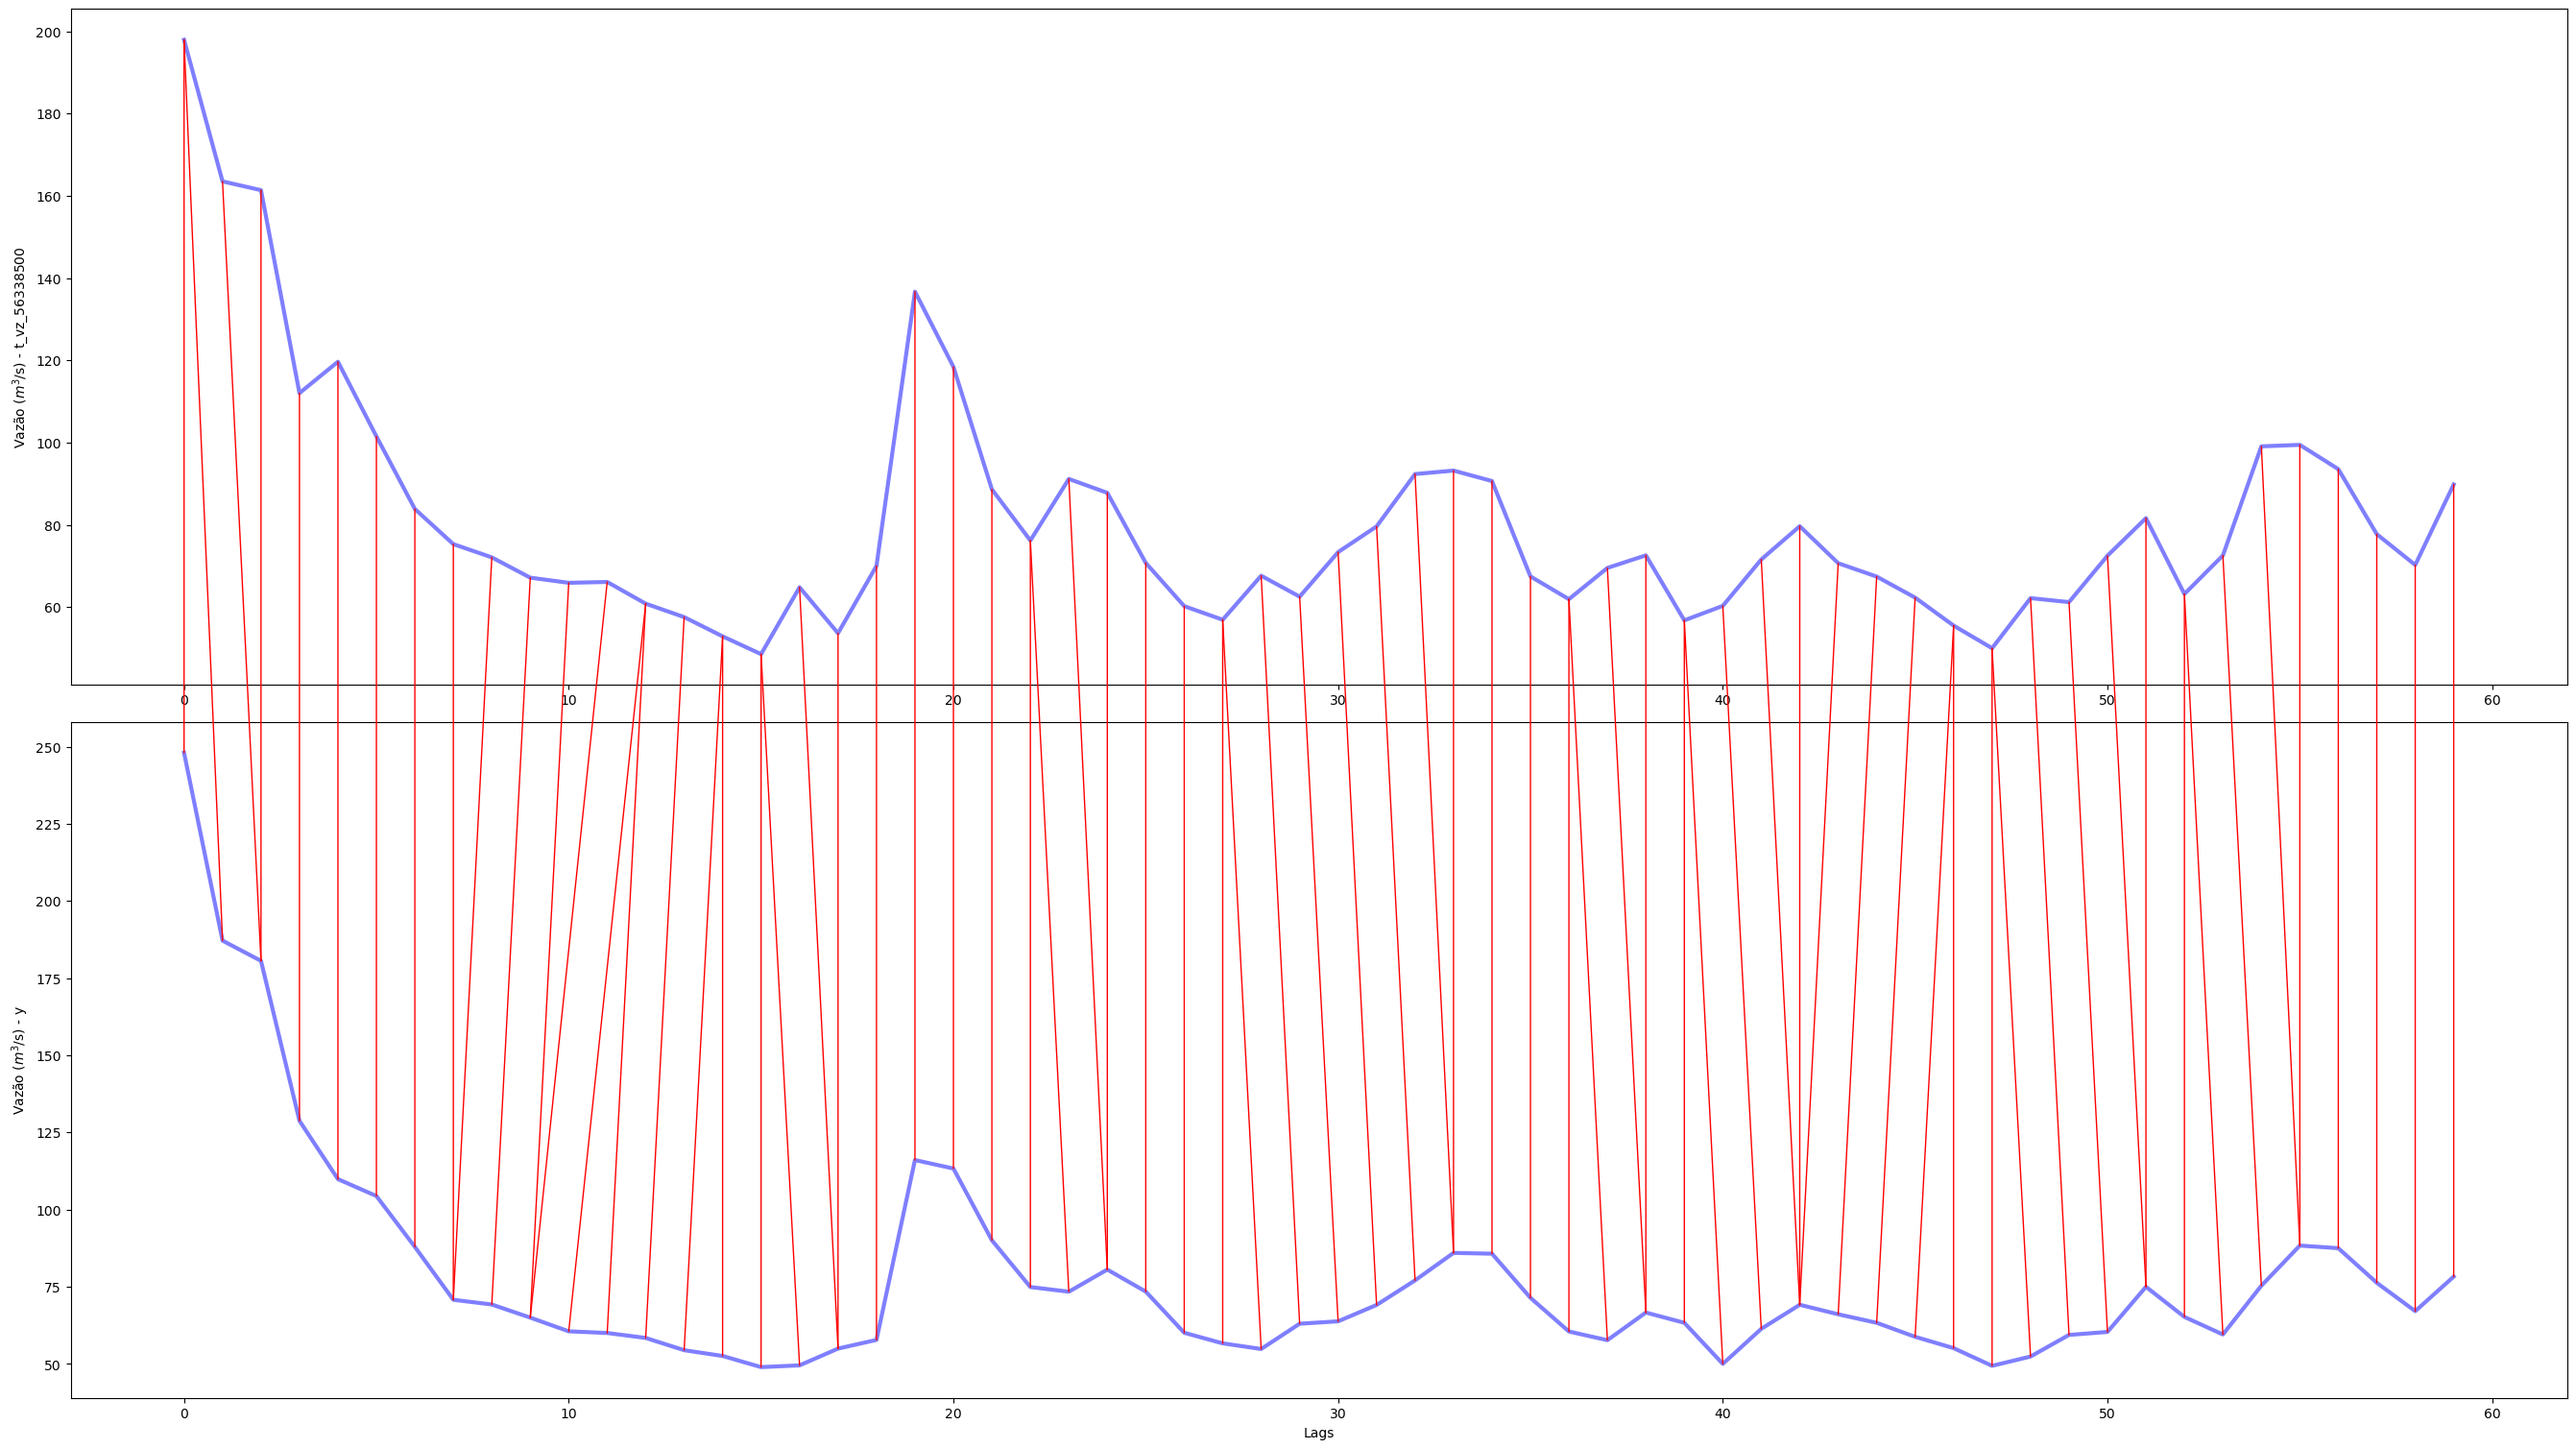

In [61]:
import matplotlib.pyplot as plt
from dtaidistance import dtw_visualisation as dtw_vis
from dtaidistance import dtw

dtw_dist = dtw.distance_matrix_fast(df_aux.drop(columns=['ds', 'unique_id']).T.values)
df_dtw_dist = pd.DataFrame(
    data=dtw_dist,
    index=df_aux.drop(columns=['ds', 'unique_id']).columns.to_list(),
    columns=df_aux.drop(columns=['ds', 'unique_id']).columns.to_list(),
)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(2560/96, 1440/96), # um tamanho razoável
)

path = dtw.warping_path(
    from_s=df_aux['t_vz_56338500'].tail(60).T.values,
    to_s=df_aux['y'].tail(60).T.values,
)

dtw_vis.plot_warping(
    s1=df_aux['t_vz_56338500'].tail(60).T.values,
    s2=df_aux['y'].tail(60).T.values,
    path=path,
    fig=fig,
    axs=axs,
    series_line_options={
        'linewidth': 3.0,
        'color': 'blue',
        'alpha': 0.5},
    warping_line_options={
        'linewidth': 1.0,
        'color': 'red',
        'alpha': 1.0},
)

axs[1].set_xlabel("Lags")
axs[0].set_ylabel("Vazão ($m^3$/s) - t_vz_56338500")
axs[1].set_ylabel("Vazão ($m^3$/s) - y")
fig.show()

### Granger-causality

In [53]:
from statsmodels.tsa.stattools import grangercausalitytests

#vazões ['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500']
#chuvas ['t_cv_56425000', 't_cv_56338500', 't_cv_56110005', 't_cv_56337200', 't_cv_56337500']
df_granger = pd.DataFrame()
df_granger = df_aux.drop(columns=['ds', 'unique_id']).diff(1) # aplica essa diferenciação pra remover qq efeito de tendência
df_granger = df_granger.dropna()
grangercausalitytests(df_granger[['y', 't_cv_56337500']].tail(30), maxlag=7, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9968  , p=0.0342  , df_denom=26, df_num=1
ssr based chi2 test:   chi2=5.5733  , p=0.0182  , df=1
likelihood ratio test: chi2=5.0978  , p=0.0240  , df=1
parameter F test:         F=4.9968  , p=0.0342  , df_denom=26, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.4613  , p=0.0059  , df_denom=23, df_num=2
ssr based chi2 test:   chi2=15.7318 , p=0.0004  , df=2
likelihood ratio test: chi2=12.4844 , p=0.0019  , df=2
parameter F test:         F=6.4613  , p=0.0059  , df_denom=23, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.4424  , p=0.0151  , df_denom=20, df_num=3
ssr based chi2 test:   chi2=17.9918 , p=0.0004  , df=3
likelihood ratio test: chi2=13.7874 , p=0.0032  , df=3
parameter F test:         F=4.4424  , p=0.0151  , df_denom=20, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7217  , p=0.0237  , df_d

{1: ({'ssr_ftest': (4.996755984283574, 0.034199745051889385, 26.0, 1),
   'ssr_chi2test': (5.573304751700909, 0.0182363108573868, 1),
   'lrtest': (5.097794444269937, 0.02395628585638881, 1),
   'params_ftest': (4.996755984283572, 0.034199745051889385, 26.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (6.461255633438089, 0.005931344962990116, 23.0, 2),
   'ssr_chi2test': (15.731752846631867, 0.00038361296269175647, 2),
   'lrtest': (12.484358259408395, 0.0019456111609435095, 2),
   'params_ftest': (6.46125563343808, 0.005931344962990152, 23.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.4424127214192906, 0.015088849279040339, 20.0, 3),
   'ssr_chi2test': (17.991771521748127, 0.00044157175747168133, 3),
   'lrtest': (13.787354303289902, 0.003209364287356957, 3),
   'params_ftest': (4.442412721419291, 0.015088849279040313, 20.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [

# Variáveis globais

In [54]:
look_back = 2 # Lags a serem utilizadas. Retirei esse número do gráfico PACF. Lá ele indica 2 lags apenas, mas resolvi usar uma a mais
fh_v = [3, 5, 7, 10, 15] # Horizonte de Previsão (como a frequência dos dados é diária, isso significa "fch" dias)
pasta_resultados = "./resultados/trecho_alto/"

fh_artigo = [1, 3, 7] # Horizonte de Previsão inspirado no artigo da Alemanha

# Nixtla

## Separação dos dados

In [29]:
# Criação de um conjunto de validação de apenas 30 registros (último mês de dados na base de dados)
# Será com este conjunto que as previsões serão realizadas.
# Nos conjuntos de treino/teste farei a otimização da pilha de modelos e gerarei os dados de input para o meta-regressor

df_valid = df_aux.tail(30).copy()
df_valid

,ds,unique_id,y,t_cv_56425000,t_cv_56338500,t_cv_56110005,t_cv_56337200,t_cv_56337500,t_vz_56338500,t_vz_56110005,t_vz_56337200,t_vz_56337500
3987,2023-12-02,1,63.825208,0.6,0.0,0.0,0.0,0.0,73.371667,41.735625,52.110000,26.462500
3988,2023-12-03,1,69.127188,3.8,0.0,0.0,0.0,0.0,79.623333,47.615217,57.680870,35.486667
3989,2023-12-04,1,77.093958,0.6,0.0,0.4,0.2,20.8,92.354167,56.256250,63.264583,33.537917
3990,2023-12-05,1,85.991771,0.0,0.0,0.0,0.0,0.2,93.197083,62.799167,69.332609,34.711250
3991,2023-12-06,1,85.735625,0.0,0.8,0.0,26.0,0.0,90.656087,52.991875,64.587391,25.325833
3992,2023-12-07,1,71.439583,0.0,0.0,0.0,0.0,0.6,67.468696,48.743696,59.132609,27.354167
3993,2023-12-08,1,60.521250,0.0,0.0,0.0,0.0,0.0,61.935833,45.002083,56.076522,22.638696
3994,2023-12-09,1,57.715833,0.0,0.0,0.0,0.0,0.0,69.533043,44.781146,57.503333,24.855833
3995,2023-12-10,1,66.672292,0.0,0.0,0.0,0.0,0.0,72.591739,42.441563,55.733913,25.338333
3996,2023-12-11,1,63.341146,0.0,0.0,0.6,0.0,0.2,56.789583,42.353370,54.429583,19.257917


In [30]:
df_aux_crpd = df_aux.drop(index=df_valid.index)
df_aux_crpd

,ds,unique_id,y,t_cv_56425000,t_cv_56338500,t_cv_56110005,t_cv_56337200,t_cv_56337500,t_vz_56338500,t_vz_56110005,t_vz_56337200,t_vz_56337500
0,2013-01-01,1,82.787100,0.241148,0.202105,0.0,0.437702,0.551181,79.298366,60.056100,49.154342,29.104130
1,2013-01-02,1,80.489300,0.174561,0.024937,0.0,0.168651,0.000000,80.660440,46.950000,34.521715,41.121955
2,2013-01-03,1,78.214200,0.588994,0.848283,0.0,0.322936,0.566388,82.201442,46.703125,38.586211,51.963603
3,2013-01-04,1,79.348900,0.317681,0.425111,0.0,0.093011,0.288712,76.099995,49.239583,48.206779,17.611111
4,2013-01-05,1,129.161000,2.034343,0.869555,0.0,1.522630,1.933175,108.219680,49.780208,63.708133,22.068745
...,...,...,...,...,...,...,...,...,...,...,...,...
3982,2023-11-27,1,73.457813,0.000000,0.000000,0.0,0.000000,0.000000,70.747083,43.760000,53.198696,24.004167
3983,2023-11-28,1,60.119022,0.000000,0.000000,0.0,0.000000,0.000000,60.241250,34.390000,51.586250,22.428333
3984,2023-11-29,1,56.684063,0.000000,0.000000,0.2,3.400000,8.200000,56.936667,41.340000,50.151250,21.205417
3985,2023-11-30,1,54.854792,1.000000,0.000000,0.6,0.000000,0.200000,67.640435,38.145000,49.644583,21.615417


In [31]:
df_train, df_test = temporal_train_test_split(df_aux_crpd, test_size=0.2, anchor="start")

In [32]:
plot_divisao_treino_teste(
    df_treino=df_train,
    df_teste=df_test,
    col_data='ds',
    col_plot='y',
    salvar=False, #SALVAR_PLOTS
)

## StatsForecast

### Baseline - ARIMA

Aplicação do modelo ARIMA para gerar uma baseline inicial. O ARIMA trabalha apenas com séries univariadas, de modo que precisará gerar dados de input diferenciados.

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

modelo = [AutoARIMA(season_length=365)]

sfc = StatsForecast( 
    models=modelo,
    freq='D', 
    n_jobs=-1,
)

In [ ]:
df_input_arima = df_train[['ds', 'unique_id', 'y']]



## Vazões exógenas calculadas no fch

### Stacking Ensemble

In [ ]:
# Implementando da forma no artigo:
# https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28



In [34]:
# Separando os dados de treinamento (df_train) em 80/20 para realizar as otimizações nos modelos-base

df_train_opt, df_test_opt = temporal_train_test_split(df_train, test_size=0.2, anchor="start")

In [35]:
df_train_opt

,ds,unique_id,y,t_cv_56425000,t_cv_56338500,t_cv_56110005,t_cv_56337200,t_cv_56337500,t_vz_56338500,t_vz_56110005,t_vz_56337200,t_vz_56337500
0,2013-01-01,1,82.7871,0.241148,0.202105,0.0,0.437702,0.551181,79.298366,60.056100,49.154342,29.104130
1,2013-01-02,1,80.4893,0.174561,0.024937,0.0,0.168651,0.000000,80.660440,46.950000,34.521715,41.121955
2,2013-01-03,1,78.2142,0.588994,0.848283,0.0,0.322936,0.566388,82.201442,46.703125,38.586211,51.963603
3,2013-01-04,1,79.3489,0.317681,0.425111,0.0,0.093011,0.288712,76.099995,49.239583,48.206779,17.611111
4,2013-01-05,1,129.1610,2.034343,0.869555,0.0,1.522630,1.933175,108.219680,49.780208,63.708133,22.068745
...,...,...,...,...,...,...,...,...,...,...,...,...
2546,2019-12-22,1,97.9221,0.000000,0.000000,0.0,0.000000,0.000000,58.208333,53.823958,62.320833,8.778244
2547,2019-12-23,1,99.1783,25.000000,0.200000,24.4,10.600000,0.000000,78.962500,70.183333,70.862500,54.172600
2548,2019-12-24,1,147.7250,8.400000,0.000000,10.0,7.600000,0.000000,119.991667,75.378125,81.991667,6.700773
2549,2019-12-25,1,159.0910,0.200000,0.000000,0.0,0.000000,0.000000,122.945833,113.178125,102.312500,53.520591


In [36]:
df_test_opt

,ds,unique_id,y,t_cv_56425000,t_cv_56338500,t_cv_56110005,t_cv_56337200,t_cv_56337500,t_vz_56338500,t_vz_56110005,t_vz_56337200,t_vz_56337500
2551,2019-12-27,1,164.8850,1.4,0.0,0.0,0.0,0.0,92.366667,78.650000,96.066667,39.834123
2552,2019-12-28,1,122.7240,2.0,0.0,0.6,0.0,0.0,71.654167,61.879167,78.333333,19.982997
2553,2019-12-29,1,106.8320,2.2,0.0,0.0,3.2,0.0,60.020833,53.922917,63.737500,11.554846
2554,2019-12-30,1,100.4400,0.2,0.0,0.0,0.2,0.0,55.166667,51.446875,59.779167,6.901397
2555,2019-12-31,1,95.4265,0.0,0.0,0.0,0.0,0.0,50.637500,49.546875,57.587500,6.947803
...,...,...,...,...,...,...,...,...,...,...,...,...
3184,2021-09-20,1,48.5498,0.0,0.0,0.0,0.0,0.0,38.555000,22.630000,10.350833,6.922625
3185,2021-09-21,1,48.5498,0.0,0.0,0.0,0.0,0.0,34.349583,20.935000,10.248333,7.944341
3186,2021-09-22,1,48.5498,0.0,0.0,0.0,0.0,0.0,37.307292,23.950000,9.918333,7.665001
3187,2021-09-23,1,45.6375,0.0,0.0,17.0,0.0,0.0,37.963542,21.859500,9.272083,6.577507


### Busca por hiperparâmetros

In [37]:
reexecutar = False
if reexecutar:
    # def opt_lgbm(trial):
    #     # Parâmetros para o modelo
    #     prmtrs_fixos = {
    #         'metric' : 'mape',
    #         'verbosity' : -1,
    #         'random_state' : 42,
    #     }

    #     prmtrs_avaliados = {
    #         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10.0),
    #         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-5, 10.0),
    #         'num_leaves' : trial.suggest_int('num_leaves', 2, 64),
    #         'n_estimators' : trial.suggest_int('n_estimators', 2, 256),
    #         'feature_fraction': trial.suggest_loguniform('feature_fraction', 1e-2, 0.99),
    #         'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 2, 256),
    #         'bagging_fraction' : trial.suggest_loguniform('bagging_fraction', 1e-2, 0.99),
    #         'bagging_freq' : trial.suggest_int('bagging_freq', 1, 15),
    #     }

    #     modelo = [LGBMRegressor(**prmtrs_fixos, **prmtrs_avaliados)]

    #     # Este parâmetro "date_features" da lib MLForecast pode ser otimizado
    #     #   E essa coisinha simples pode melhorar bastante o resultado
    #     date_features = []
    #     dayofyear = trial.suggest_categorical('dayofyear', [True, False])
    #     week = trial.suggest_categorical('week', [True, False])
    #     month = trial.suggest_categorical('month', [True, False])
    #     quarter = trial.suggest_categorical('quarter', [True, False])
    #     year = trial.suggest_categorical('year', [True, False])

    #     if dayofyear: date_features.append('dayofyear')
    #     if week: date_features.append('week')
    #     if month: date_features.append('month')
    #     if quarter: date_features.append('quarter')
    #     if year: date_features.append('year')
    
    #     fcst = mlf.MLForecast(
    #         models=modelo,
    #         freq='D',
    #         lags=[i+1 for i in range(look_back)],
    #         date_features=date_features,
    #     )

    #     fcst.fit(df_train_opt, id_col='unique_id', time_col='ds', target_col='y', static_features=[])
    #     df_futr = df_test_opt.drop(columns=['y'])
    #     p = fcst.predict(h=len(df_test_opt), X_df=df_futr)
    #     df_result = pd.merge(left=p, right=df_test_opt[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

    #     loss = mape(df_result['y'], df_result['LGBMRegressor'])
        
    #     return loss

    # def opt_lsvr(trial):
    #     # Parâmetros para o regressor
    #     params = {
    #         'loss' : trial.suggest_categorical('loss', ['epsilon_insensitive', 'squared_epsilon_insensitive']),
    #         'intercept_scaling' : trial.suggest_loguniform('intercept_scaling', 1e-3, 5.0),
    #         'tol' : trial.suggest_loguniform('tol', 1e-3, 5.0),
    #         'C' : trial.suggest_loguniform('C', 1e-3, 5.0),
    #         'epsilon' : trial.suggest_loguniform('epsilon', 1e-3, 5.0)
    #     }

    #     model = [LinearSVR(random_state=42, **params)]

    #     # Este parâmetro "date_features" da lib MLForecast pode ser otimizado
    #     #   E essa coisinha simples pode melhorar bastante o resultado
    #     date_features = []
    #     dayofyear = trial.suggest_categorical('dayofyear', [True, False])
    #     week = trial.suggest_categorical('week', [True, False])
    #     month = trial.suggest_categorical('month', [True, False])
    #     quarter = trial.suggest_categorical('quarter', [True, False])
    #     year = trial.suggest_categorical('year', [True, False])

    #     if dayofyear: date_features.append('dayofyear')
    #     if week: date_features.append('week')
    #     if month: date_features.append('month')
    #     if quarter: date_features.append('quarter')
    #     if year: date_features.append('year')

    #     fcst = mlf.MLForecast(
    #         models=model,
    #         freq='D',
    #         lags=[i+1 for i in range(look_back)],
    #         date_features=date_features,
    #     )

    #     fcst.fit(df_train_opt, id_col='unique_id', time_col='ds', target_col='y', static_features=[])
    #     df_futr = df_test_opt.drop(columns=['y'])
    #     p = fcst.predict(h=len(df_test_opt), X_df=df_futr)
    #     df_result = pd.merge(left=p, right=df_test_opt[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

    #     loss = mape(df_result['y'], df_result['LinearSVR'])

    #     return loss

    def opt_en(trial):

        # Parâmetros para o regressor
        params = {
            'alpha' : trial.suggest_loguniform('alpha', 1e-5, 2.0),
            'l1_ratio' : trial.suggest_loguniform('l1_ratio', 1e-5, 1.0),
            'tol' : trial.suggest_loguniform('tol', 1e-5, 5.0),
            'random_state' : trial.suggest_int('random_state', 1, 50),
        }

        model = [ElasticNet(**params)]

        # Este parâmetro "date_features" da lib MLForecast pode ser otimizado
        #   E essa coisinha simples pode melhorar bastante o resultado
        date_features = []
        dayofyear = trial.suggest_categorical('dayofyear', [True, False])
        week = trial.suggest_categorical('week', [True, False])
        month = trial.suggest_categorical('month', [True, False])
        quarter = trial.suggest_categorical('quarter', [True, False])
        year = trial.suggest_categorical('year', [True, False])

        if dayofyear: date_features.append('dayofyear')
        if week: date_features.append('week')
        if month: date_features.append('month')
        if quarter: date_features.append('quarter')
        if year: date_features.append('year')

        fcst = mlf.MLForecast(
            models=model,
            freq='D',
            lags=[i+1 for i in range(look_back)],
            date_features=date_features,
        )

        fcst.fit(df_train_opt, id_col='unique_id', time_col='ds', target_col='y', static_features=[])
        df_futr = df_test_opt.drop(columns=['y'])
        p = fcst.predict(h=len(df_test_opt), X_df=df_futr)
        df_result = pd.merge(left=p, right=df_test_opt[['ds', 'y']], on=['ds'], how='left')

        loss = mape(df_result['y'], df_result['ElasticNet'])

        return loss

    # def opt_knn(trial):
    #     model = [
    #         KNeighborsRegressor(
    #             n_neighbors=trial.suggest_int('n_neighbors', 1, 20),
    #             weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
    #             p=trial.suggest_float('p', 1, 2)
    #         )
    #     ]

    #     # Este parâmetro "date_features" da lib MLForecast pode ser otimizado
    #     #   E essa coisinha simples pode melhorar bastante o resultado
    #     date_features = []
    #     dayofyear = trial.suggest_categorical('dayofyear', [True, False])
    #     week = trial.suggest_categorical('week', [True, False])
    #     month = trial.suggest_categorical('month', [True, False])
    #     quarter = trial.suggest_categorical('quarter', [True, False])
    #     year = trial.suggest_categorical('year', [True, False])

    #     if dayofyear: date_features.append('dayofyear')
    #     if week: date_features.append('week')
    #     if month: date_features.append('month')
    #     if quarter: date_features.append('quarter')
    #     if year: date_features.append('year')

    #     fcst = mlf.MLForecast(
    #         models=model,
    #         freq='D',
    #         lags=[i+1 for i in range(look_back)],
    #         date_features=date_features,
    #     )

    #     fcst.fit(df_train_opt, id_col='unique_id', time_col='ds', target_col='y', static_features=[])
    #     df_futr = df_test_opt.drop(columns=['y'])
    #     p = fcst.predict(h=len(df_test_opt), X_df=df_futr)
    #     df_result = pd.merge(left=p, right=df_test_opt[['ds', 'y']], on=['ds'], how='left')

    #     loss = mape(df_result['y'], df_result['KNeighborsRegressor'])

    #     return loss

    ############################

    # study_lgbm = opt.create_study(direction='minimize', sampler=opt.samplers.TPESampler(seed=42))
    # study_lsvr = opt.create_study(direction='minimize', sampler=opt.samplers.TPESampler(seed=42))
    study_en = opt.create_study(direction='minimize', sampler=opt.samplers.TPESampler(seed=42))
    # study_knn = opt.create_study(direction='minimize', sampler=opt.samplers.TPESampler(seed=42))

    # study_lgbm.optimize(opt_lgbm, timeout=600, catch=(FloatingPointError, ValueError, ), n_jobs=6, show_progress_bar=True)
    # study_lsvr.optimize(opt_lsvr, timeout=600, catch=(FloatingPointError, ValueError, ), n_jobs=6, show_progress_bar=True)
    study_en.optimize(opt_en, timeout=900, catch=(FloatingPointError, ValueError, ), n_jobs=6, show_progress_bar=True)
    # study_knn.optimize(opt_knn, timeout=600, catch=(FloatingPointError, ValueError, ), n_jobs=6, show_progress_bar=True)

    # lgbm_best_trial = {
    #     'modelo' : 'LightGBM',
    #     'best_value' : study_lgbm.best_value,
    #     'best_params' : study_lgbm.best_params,
    # }

    # lsvr_best_trial = {
    #     'modelo' : 'LinearSVR',
    #     'best_value' : study_lsvr.best_value,
    #     'best_params' : study_lsvr.best_params,
    # }

    en_best_trial = {
        'modelo' : 'ElasticNet',
        'best_value' : study_en.best_value,
        'best_params' : study_en.best_params,
    }

    # knn_best_trial = {
    #     'modelo' : 'KNeighborsRegressor',
    #     'best_value' : study_knn.best_value,
    #     'best_params' : study_knn.best_params,
    # }

    ############################

    salvar = True
    if salvar:
        # Exportar os melhores parâmetros para um arquivo JSON
        dh = datetime.now()
        # arq_lgbm = "lgbm_best_trial_{dt}.json".format(dt=dh.strftime("%Y-%m-%d_%H-%M-%S"))
        # arq_lsvr = "lsvr_best_trial_{dt}.json".format(dt=dh.strftime("%Y-%m-%d_%H-%M-%S"))
        arq_en = "en_best_trial_{dt}.json".format(dt=dh.strftime("%Y-%m-%d_%H-%M-%S"))
        # arq_knn = "knn_best_trial_{dt}.json".format(dt=dh.strftime("%Y-%m-%d_%H-%M-%S"))
        # exportar_dict_json(lgbm_best_trial, "./resultados/trecho_alto/", arq_lgbm)
        # exportar_dict_json(lsvr_best_trial, "./resultados/trecho_alto/", arq_lsvr)
        exportar_dict_json(en_best_trial, "./resultados/trecho_alto/", arq_en)
        # exportar_dict_json(knn_best_trial, "./resultados/trecho_alto/", arq_knn)

In [38]:
# Já tem uma execução feita
# Vou carregar os dados de lá

# arq_lgbm = "lgbm_best_trial_2024-04-21_17-41-52.json"
# arq_lsvr = "lsvr_best_trial_2024-04-21_17-41-52.json"
arq_en = "en_best_trial_2024-04-22_14-12-50.json"
# arq_knn = "knn_best_trial_2024-04-21_17-41-52.json"

In [39]:
# Uma vez os modelos otimizados, carrego as configs dos arquivos e faz fit em todo "df_train" predict em "df_test"

# with open("./resultados/trecho_alto/"+arq_lgbm, "r") as f:
#     lgbm_params = json.load(f)

# with open("./resultados/trecho_alto/"+arq_lsvr, "r") as f:
#     lsvr_params = json.load(f)

with open("./resultados/trecho_alto/"+arq_en, "r") as f:
    en_params = json.load(f)

# with open("./resultados/trecho_alto/"+arq_knn, "r") as f:
#     knn_params = json.load(f)

# print("LGBM")
# print("Best score:", lgbm_params['best_value'])
# print("Params:")
# for key, value in lgbm_params['best_params'].items():
#     print("\t{}: {}".format(key, value))

# print("><><><><><")

# print("LSVR")
# print("Best score:", lsvr_params['best_value'])
# print("Params: ")
# for key, value in lsvr_params['best_params'].items():
#     print("\t{}: {}".format(key, value))

print("><><><><><")

print("EN")
print("Best score:", en_params['best_value'])
print("Params: ")
for key, value in en_params['best_params'].items():
    print("\t{}: {}".format(key, value))

print("><><><><><")

# print("KNN")
# print("Best score:", knn_params['best_value'])
# print("Params: ")
# for key, value in knn_params['best_params'].items():
#     print("\t{}: {}".format(key, value))

><><><><><
EN
Best score: 0.1228410456680531
Params: 
	alpha: 1.9742085061691228
	l1_ratio: 0.9951340270562706
	tol: 1.0294716605563285e-05
	random_state: 13
	dayofyear: False
	week: False
	month: False
	quarter: False
	year: False
><><><><><


In [40]:
# Agora faz fit no conjunto "df_train" inteiro e predict no "df_test"

# m_lgbm = [
#     LGBMRegressor(
#         metric='mape',
#         verbosity=-1,
#         random_state=42,
#         lambda_l1=lgbm_params['best_params']['lambda_l1'],
#         lambda_l2=lgbm_params['best_params']['lambda_l2'],
#         bagging_freq=lgbm_params['best_params']['bagging_freq'],
#         num_leaves=lgbm_params['best_params']['num_leaves'],
#         n_estimators=lgbm_params['best_params']['n_estimators'],
#         min_data_in_leaf=lgbm_params['best_params']['min_data_in_leaf'],
#         bagging_fraction=lgbm_params['best_params']['bagging_fraction'],
#         feature_fraction=lgbm_params['best_params']['feature_fraction']
#     )
# ]

# date_features = []
# if lgbm_params['best_params']['dayofyear']: date_features.append('dayofyear')
# if lgbm_params['best_params']['week']: date_features.append('week')
# if lgbm_params['best_params']['month']: date_features.append('month')
# if lgbm_params['best_params']['quarter']: date_features.append('quarter')
# if lgbm_params['best_params']['year']: date_features.append('year')

# fcst_lgbm = mlf.MLForecast(
#     models=m_lgbm,
#     freq='D',
#     lags=[i+1 for i in range(look_back)],
#     date_features=date_features
# )

# fcst_lgbm.fit(
#     df=df_train,
#     id_col='unique_id',
#     time_col='ds',
#     target_col='y',
#     static_features=[]
# )

df_futr = df_test.drop(columns=['y'])
# p = fcst_lgbm.predict(
#     h=len(df_test),
#     X_df=df_futr
# )

# df_input_meta = pd.merge(
#     left=p,
#     right=df_test[['ds', 'unique_id', 'y']],
#     on=['ds', 'unique_id'],
#     how='left'
# )

############################

# m_lsvr = [
#     LinearSVR(
#         random_state=42,
#         C=lsvr_params['best_params']['C'],
#         tol=lsvr_params['best_params']['tol'],
#         loss=lsvr_params['best_params']['loss'],
#         epsilon=lsvr_params['best_params']['epsilon'],
#         intercept_scaling=lsvr_params['best_params']['intercept_scaling']
#     )
# ]

# date_features = []
# if lsvr_params['best_params']['dayofyear']: date_features.append('dayofyear')
# if lsvr_params['best_params']['week']: date_features.append('week')
# if lsvr_params['best_params']['month']: date_features.append('month')
# if lsvr_params['best_params']['quarter']: date_features.append('quarter')
# if lsvr_params['best_params']['year']: date_features.append('year')

# fcst_lsvr = mlf.MLForecast(
#     models=m_lsvr,
#     freq='D',
#     lags=[i+1 for i in range(look_back)],
#     date_features=date_features
# )

# fcst_lsvr.fit(
#     df=df_train,
#     id_col='unique_id',
#     time_col='ds',
#     target_col='y',
#     static_features=[]
# )

# p = fcst_lsvr.predict(
#     h=len(df_test),
#     X_df=df_futr
# )

# df_input_meta = pd.merge(
#     left=p,
#     right=df_input_meta,
#     on=['ds', 'unique_id'],
#     how='left'
# )

############################

m_en = [
    ElasticNet(
        random_state=en_params['best_params']['random_state'],
        alpha=en_params['best_params']['alpha'],
        tol=en_params['best_params']['tol'],
        l1_ratio=en_params['best_params']['l1_ratio']
    )
]

date_features = []
if en_params['best_params']['dayofyear']: date_features.append('dayofyear')
if en_params['best_params']['week']: date_features.append('week')
if en_params['best_params']['month']: date_features.append('month')
if en_params['best_params']['quarter']: date_features.append('quarter')
if en_params['best_params']['year']: date_features.append('year')

fcst_en = mlf.MLForecast(
    models=m_en,
    freq='D',
    lags=[i+1 for i in range(look_back)],
    date_features=date_features
)

fcst_en.fit(
    df=df_train,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=[]
)

p = fcst_en.predict(
    h=len(df_test),
    X_df=df_futr
)

df_input_meta = pd.merge(
    left=p,
    right=df_test[['ds', 'unique_id', 'y']],
    on=['ds', 'unique_id'],
    how='left'
)

# df_input_meta = pd.merge(
#     left=p,
#     right=df_input_meta,
#     on=['ds', 'unique_id'],
#     how='left'
# )

############################

# m_knn = [
#     KNeighborsRegressor(
#         n_neighbors=knn_params['best_params']['n_neighbors'],
#         weights=knn_params['best_params']['weights'],
#         p=knn_params['best_params']['p']
#     )
# ]

# fcst_knn = mlf.MLForecast(
#     models=m_knn,
#     freq='D',
#     lags=[i+1 for i in range(look_back)],
#     date_features=date_features
# )

# fcst_knn.fit(
#     df=df_train,
#     id_col='unique_id',
#     time_col='ds',
#     target_col='y',
#     static_features=[]
# )

# pred_knn = fcst_knn.predict(
#     h=len(df_test),
#     X_df=df_futr
# )

# df_input_meta = pd.merge(
#     left=pred_knn,
#     right=df_input_meta,
#     on=['ds', 'unique_id'],
#     how='left'
# )

In [41]:
df_input_meta

,unique_id,ds,ElasticNet,y
0,1,2021-09-25,40.764301,36.395300
1,1,2021-09-26,41.530203,41.853400
2,1,2021-09-27,40.593560,39.091100
3,1,2021-09-28,41.917763,38.185000
4,1,2021-09-29,41.904331,41.853400
...,...,...,...,...
793,1,2023-11-27,92.969219,73.457813
794,1,2023-11-28,81.668926,60.119022
795,1,2023-11-29,77.025938,56.684063
796,1,2023-11-30,78.496789,54.854792


In [42]:
metrics = {}
# metrics['LGBMRegressor'] = {
#     'MAPE': mape(df_input_meta['y'], df_input_meta['LGBMRegressor']),
#     'RMSE': rmse(df_input_meta['y'], df_input_meta['LGBMRegressor']),
#     'MAE' : mae(df_input_meta['y'], df_input_meta['LGBMRegressor'])
# }

# metrics['LinearSVR'] = {
#     'MAPE': mape(df_input_meta['y'], df_input_meta['LinearSVR']),
#     'RMSE': rmse(df_input_meta['y'], df_input_meta['LinearSVR']),
#     'MAE' : mae(df_input_meta['y'], df_input_meta['LinearSVR'])
# }

metrics['ElasticNet'] = {
    'MAPE': mape(
        df_input_meta['y'],
        df_input_meta['ElasticNet']
    ),
    'RMSE': rmse(
        df_input_meta['y'],
        df_input_meta['ElasticNet']
    ),
    'MAE' : mae(
        df_input_meta['y'],
        df_input_meta['ElasticNet']
    )
}

# metrics['KNeighborsRegressor'] = {
#     'MAPE': mape(df_input_meta['y'], df_input_meta['KNeighborsRegressor']),
#     'RMSE': rmse(df_input_meta['y'], df_input_meta['KNeighborsRegressor']),
#     'MAE' : mae(df_input_meta['y'], df_input_meta['KNeighborsRegressor'])
# }

df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo") # Usado para preencher a tabela com as métricas

fig = make_subplots(
    rows=2,
    cols=1,
    vertical_spacing=0.2,
    specs=[
        [{"type": "scatter"}],
        [{"type": "table"}]
    ]
)

fig.add_trace(
    go.Scatter(
        x=df_input_meta['ds'],
        y=df_input_meta['y'],
        mode='lines',
        name='observado',
        line=dict(
            color="black",
            width=4
        )
    ),
    row=1, col=1
)

# fig.add_trace(
#     go.Scatter(
#         x=df_input_meta['ds'],
#         y=df_input_meta['LGBMRegressor'],
#         mode='lines',
#         name='LGBM'
#     ),
#     row=1, col=1
# )

# fig.add_trace(
#     go.Scatter(
#         x=df_input_meta['ds'],
#         y=df_input_meta['LinearSVR'],
#         mode='lines',
#         name='LinearSVR'
#     ),
#     row=1, col=1
# )

fig.add_trace(
    go.Scatter(
        x=df_input_meta['ds'],
        y=df_input_meta['ElasticNet'],
        mode='lines',
        name='ElasticNet'
        ),
    row=1, col=1
)

# fig.add_trace(
#     go.Scatter(
#         x=df_input_meta['ds'],
#         y=df_input_meta['KNeighborsRegressor'],
#         mode='lines',
#         name='KNeighborsRegressor'
#     ),
#     row=1, col=1
# )

fig.add_trace(
    go.Table(
        header=dict(
            values=df_tbl.columns.to_list(),
            font=dict(size=14),
            align="center"
        ),
        cells=dict(
            values=df_tbl.T,
            font=dict(size=12),
            height=24,
            align="left"
        )
    ),
    row=2, col=1
)

fig.update_yaxes(
    title=dict(
        text="Vazão (m³/s)",
        font=dict(
            family="system-ui",
            size=18
        )
    ),
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    #gridcolor='lightgrey'
)

fig.update_xaxes(
    title=dict(
        text="Período",
        font=dict(
            family="system-ui",
            size=18
        )
    ),
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    #gridcolor='lightgrey'
)

fig.update_traces(
    hovertemplate=None,
    row=1,
    col=1
)

fig.update_layout(
    width=1500,
    height=1000,
    hovermode='x unified',
    title=dict(
        text="Modelos base otimizados",
        font=dict(
            family="system-ui",
            size=24
        )
    )
)

# salvar = False
# if salvar:
#     now = datetime.now()
#     fig.write_image("./resultados/trecho_alto/fch{fh}/opt/ml_{dt}.png".format(fh=f, dt=now.strftime("%Y-%m-%d_%H-%M-%S")))
# else:
fig.show()

In [46]:
from mlforecast.utils import PredictionIntervals

for fh in fh_artigo:
    # m_lgbm = [
    #     LGBMRegressor(
    #         metric='mape',
    #         verbosity=-1,
    #         random_state=SEED,
    #         lambda_l1=lgbm_params['best_params']['lambda_l1'],
    #         lambda_l2=lgbm_params['best_params']['lambda_l2'],
    #         bagging_freq=lgbm_params['best_params']['bagging_freq'],
    #         num_leaves=lgbm_params['best_params']['num_leaves'],
    #         n_estimators=lgbm_params['best_params']['n_estimators'],
    #         min_data_in_leaf=lgbm_params['best_params']['min_data_in_leaf'],
    #         bagging_fraction=lgbm_params['best_params']['bagging_fraction'],
    #         feature_fraction=lgbm_params['best_params']['feature_fraction']
    #     )
    # ]

    # date_features = []
    # if lgbm_params['best_params']['dayofyear']: date_features.append('dayofyear')
    # if lgbm_params['best_params']['week']: date_features.append('week')
    # if lgbm_params['best_params']['month']: date_features.append('month')
    # if lgbm_params['best_params']['quarter']: date_features.append('quarter')
    # if lgbm_params['best_params']['year']: date_features.append('year')

    # fcst_lgbm = mlf.MLForecast(
    #     models=m_lgbm,
    #     freq='D',
    #     lags=[i+1 for i in range(look_back)],
    #     date_features=date_features
    # )

    # fcst_lgbm.fit(
    #     df=df_test,
    #     id_col='unique_id',
    #     time_col='ds',
    #     target_col='y',
    #     static_features=[]
    # )

    # df_futr = cria_dataframe_futuro(
    #     df_futr=fcst_lgbm.make_future_dataframe(h=fh),
    #     df_train=df_test,
    #     df_test=df_valid,
    #     tp_valor='ml',
    #     n_lags=look_back,
    #     date_features=date_features,
    #     cols=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500']
    # )

    # p = fcst_lgbm.predict(
    #     h=fh,
    #     X_df=df_futr
    # )

    # df_teste_modelos = pd.merge(
    #     left=p,
    #     right=df_valid[['ds', 'unique_id', 'y']],
    #     on=['ds', 'unique_id'],
    #     how='left'
    # )

    ############################

    # m_lsvr = [
    #     LinearSVR(
    #         random_state=SEED,
    #         C=lsvr_params['best_params']['C'],
    #         tol=lsvr_params['best_params']['tol'],
    #         loss=lsvr_params['best_params']['loss'],
    #         epsilon=lsvr_params['best_params']['epsilon'],
    #         intercept_scaling=lsvr_params['best_params']['intercept_scaling']
    #     )
    # ]

    # date_features = []
    # if lsvr_params['best_params']['dayofyear']: date_features.append('dayofyear')
    # if lsvr_params['best_params']['week']: date_features.append('week')
    # if lsvr_params['best_params']['month']: date_features.append('month')
    # if lsvr_params['best_params']['quarter']: date_features.append('quarter')
    # if lsvr_params['best_params']['year']: date_features.append('year')

    # fcst_lsvr = mlf.MLForecast(
    #     models=m_lsvr,
    #     freq='D',
    #     lags=[i+1 for i in range(look_back)],
    #     date_features=date_features
    # )

    # fcst_lsvr.fit(
    #     df=df_test,
    #     id_col='unique_id',
    #     time_col='ds',
    #     target_col='y',
    #     static_features=[]
    # )

    # df_futr = cria_dataframe_futuro(
    #     df_futr=fcst_lsvr.make_future_dataframe(h=fh),
    #     df_train=df_test,
    #     df_test=df_valid,
    #     tp_valor='ml',
    #     n_lags=look_back,
    #     date_features=date_features,
    #     cols=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500']
    # )

    # p = fcst_lsvr.predict(
    #     h=fh,
    #     X_df=df_futr
    # )

    # df_teste_modelos = pd.merge(
    #     left=p,
    #     right=df_teste_modelos,
    #     on=['ds', 'unique_id'],
    #     how='left'
    # )

    ############################

    m_en = [
        ElasticNet(
            random_state=SEED,
            alpha=en_params['best_params']['alpha'],
            tol=en_params['best_params']['tol'],
            l1_ratio=en_params['best_params']['l1_ratio']
        )
    ]

    date_features = []
    if en_params['best_params']['dayofyear']: date_features.append('dayofyear')
    if en_params['best_params']['week']: date_features.append('week')
    if en_params['best_params']['month']: date_features.append('month')
    if en_params['best_params']['quarter']: date_features.append('quarter')
    if en_params['best_params']['year']: date_features.append('year')

    fcst_en = mlf.MLForecast(
        models=m_en,
        freq='D',
        lags=[i+1 for i in range(look_back)],
        date_features=date_features
    )

    fcst_en.fit(
        df=df_test,
        id_col='unique_id',
        time_col='ds',
        target_col='y',
        static_features=[],
        prediction_intervals=PredictionIntervals(n_windows=10, h=fh)
    )

    df_futr = cria_dataframe_futuro(
        df_futr=fcst_en.make_future_dataframe(h=fh),
        df_train=df_test,
        df_test=df_valid,
        tp_valor='ml',
        n_lags=look_back,
        date_features=date_features,
        cols=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500']
    )

    p = fcst_en.predict(
        level=[50, 95],
        h=fh,
        X_df=df_futr
    )

    df_teste_modelos = pd.merge(
        left=p,
        right=df_valid[['ds', 'unique_id', 'y']],
        on=['ds', 'unique_id'],
        how='left'
    )

    # df_teste_modelos = pd.merge(
    #     left=p,
    #     right=df_teste_modelos,
    #     on=['ds', 'unique_id'],
    #     how='left'
    # )

    ############################

    # m_knn = [
    #     KNeighborsRegressor(
    #         n_neighbors=knn_params['best_params']['n_neighbors'],
    #         weights=knn_params['best_params']['weights'],
    #         p=knn_params['best_params']['p']
    #     )
    # ]

    # fcst_knn = mlf.MLForecast(
    #     models=m_knn,
    #     freq='D',
    #     lags=[i+1 for i in range(look_back)],
    #     date_features=date_features
    # )

    # fcst_knn.fit(
    #     df=df_test,
    #     id_col='unique_id',
    #     time_col='ds',
    #     target_col='y',
    #     static_features=[]
    # )

    # df_futr = cria_dataframe_futuro(
    #     df_futr=fcst_knn.make_future_dataframe(h=fh),
    #     df_train=df_test,
    #     df_test=df_valid,
    #     tp_valor='ml',
    #     n_lags=look_back,
    #     date_features=date_features,
    #     cols=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500']
    # )

    # pred_knn = fcst_knn.predict(
    #     h=fh,
    #     X_df=df_futr
    # )

    # df_teste_modelos = pd.merge(
    #     left=pred_knn,
    #     right=df_teste_modelos,
    #     on=['ds', 'unique_id'],
    #     how='left'
    # )

    metrics = {}
    # metrics['LGBMRegressor'] = {
    #     'MAPE': mape(df_teste_modelos['y'], df_teste_modelos['LGBMRegressor']),
    #     'RMSE': rmse(df_teste_modelos['y'], df_teste_modelos['LGBMRegressor']),
    #     'MAE' : mae(df_teste_modelos['y'], df_teste_modelos['LGBMRegressor'])
    # }

    # metrics['LinearSVR'] = {
    #     'MAPE': mape(df_teste_modelos['y'], df_teste_modelos['LinearSVR']),
    #     'RMSE': rmse(df_teste_modelos['y'], df_teste_modelos['LinearSVR']),
    #     'MAE' : mae(df_teste_modelos['y'], df_teste_modelos['LinearSVR'])
    # }

    metrics['ElasticNet'] = {
        'MAPE': mape(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet']
        ),
        'RMSE': rmse(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet']
        ),
        'MAE' : mae(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet']
        )
    }

    metrics['ElasticNet-lo-50'] = {
        'MAPE': mape(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet-lo-50']
        ),
        'RMSE': rmse(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet-lo-50']
        ),
        'MAE' : mae(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet-lo-50']
        )
    }

    metrics['ElasticNet-hi-50'] = {
        'MAPE': mape(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet-hi-50']
        ),
        'RMSE': rmse(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet-hi-50']
        ),
        'MAE' : mae(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet-hi-50']
        )
    }

    metrics['ElasticNet-lo-95'] = {
        'MAPE': mape(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet-lo-95']
        ),
        'RMSE': rmse(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet-lo-95']
        ),
        'MAE' : mae(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet-lo-95']
        )
    }

    metrics['ElasticNet-hi-95'] = {
        'MAPE': mape(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet-hi-95']
        ),
        'RMSE': rmse(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet-hi-95']
        ),
        'MAE' : mae(
            df_teste_modelos['y'],
            df_teste_modelos['ElasticNet-hi-95']
        )
    }
    
    # metrics['KNeighborsRegressor'] = {
    #     'MAPE': mape(df_teste_modelos['y'], df_teste_modelos['KNeighborsRegressor']),
    #     'RMSE': rmse(df_teste_modelos['y'], df_teste_modelos['KNeighborsRegressor']),
    #     'MAE' : mae(df_teste_modelos['y'], df_teste_modelos['KNeighborsRegressor'])
    # }

    df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo") # Usado para preencher a tabela com as métricas

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[
            [{"type": "scatter"}], [{"type": "table"}]
        ]
    )

    # fig.add_trace(
    #     go.Scatter(
    #         x=df_teste_modelos['ds'],
    #         y=df_teste_modelos['LGBMRegressor'],
    #         mode='lines',
    #         name='LGBM'
    #     ),
    #     row=1, col=1
    # )

    # fig.add_trace(
    #     go.Scatter(
    #         x=df_teste_modelos['ds'],
    #         y=df_teste_modelos['LinearSVR'],
    #         mode='lines',
    #         name='LinearSVR'
    #     ),
    #     row=1, col=1
    # )

    fig.add_trace(
        go.Scatter(
            x=df_teste_modelos.ds,
            y=df_teste_modelos['ElasticNet-hi-95'],
            mode='lines+markers',
            name='EN-hi-95',
            line=dict(color="green")
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_teste_modelos.ds,
            y=df_teste_modelos['ElasticNet-lo-95'],
            mode='lines+markers',
            name='EN-lo-95',
            fill='tonexty',
            line=dict(color="green")
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_teste_modelos.ds,
            y=df_teste_modelos['ElasticNet-hi-50'],
            mode='lines+markers',
            name='EN-hi-50',
            line=dict(color="blue")
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_teste_modelos.ds,
            y=df_teste_modelos['ElasticNet-lo-50'],
            mode='lines+markers',
            name='EN-lo-50',
            fill='tonexty',
            line=dict(color="blue")
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_teste_modelos['ds'],
            y=df_teste_modelos['ElasticNet'],
            mode='lines+markers',
            name='ElasticNet',
            line=dict(
                color="red",
                width=4
            )
        ),
        row=1, col=1
    )

    # fig.add_trace(
    #     go.Scatter(
    #         x=df_teste_modelos['ds'],
    #         y=df_teste_modelos['KNeighborsRegressor'],
    #         mode='lines',
    #         name='KNeighborsRegressor'
    #     ),
    #     row=1, col=1
    # )

    fig.add_trace(
        go.Scatter(
            x=df_teste_modelos['ds'],
            y=df_teste_modelos['y'],
            mode='lines+markers',
            name='observado',
            line=dict(
                color="black",
                width=4
            )
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Table(
            header=dict(
                values=df_tbl.columns.to_list(),
                font=dict(size=14), align="center"
            ),
            cells=dict(
                values=df_tbl.T,
                font=dict(size=12),
                height=24,
                align="left"
            )
        ),
        row=2, col=1
    )

    fig.update_yaxes(
        title=dict(
            text="Vazão (m³/s)",
            font=dict(
                family="system-ui",
                size=18
            )
        ),
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        #gridcolor='lightgrey'
    )

    fig.update_xaxes(
        title=dict(
            text="Período",
            font=dict(
                family="system-ui",
                size=18
            )
        ),
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        #gridcolor='lightgrey'
    )

    fig.update_traces(
        hovertemplate=None,
        row=1,
        col=1
    )

    fig.update_layout(
        width=1500,
        height=1000,
        plot_bgcolor='#c8d4e3',
        hovermode='x unified',
        title=dict(
            text="Modelos base otimizados (fh={fh})".format(fh=fh),
            font=dict(
                family="system-ui",
                size=24
            )
        )
    )

    # salvar = False
    # if salvar:
    #     now = datetime.now()
    #     fig.write_image("./resultados/trecho_alto/fch{fh}/opt/ml_{dt}.png".format(fh=f, dt=now.strftime("%Y-%m-%d_%H-%M-%S")))
    # else:
    fig.show()

In [82]:
# Meta-Regressor : LSTM
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MAPE, RMSE

RESTACK = True

fhv_local = [20, 30]

for fh in fh_v:
    if RESTACK:
        df_input_meta_res = df_input_meta.copy()
        df_input_meta_res = pd.merge(
            left=df_input_meta_res,
            right=df_test[['ds', 'unique_id', 't_cv_56425000', 't_cv_56338500', 't_cv_56110005', 't_cv_56337200', 't_cv_56337500']],
            on=['ds', 'unique_id'],
            how='left'
        )

        modelo = LSTM(
            h=fh,
            random_seed=SEED,
            context_size=look_back,
            # hist_exog_list=['KNeighborsRegressor', 'LinearSVR', 'ElasticNet' , 'LGBMRegressor'],
            hist_exog_list=['ElasticNet'],
            futr_exog_list=['t_cv_56425000', 't_cv_56338500', 't_cv_56110005', 't_cv_56337200', 't_cv_56337500'],
            scaler_type='robust',
            logger=False,
            alias='MetaReg - LSTM',
            enable_progress_bar=False,
        )

        nf = NeuralForecast(
            models=[modelo],
            freq='D'
        )

        nf.fit(
            df=df_input_meta_res
        )

        df_preds = nf.predict(
            futr_df=df_valid[['ds', 'unique_id', 't_cv_56425000', 't_cv_56338500', 't_cv_56110005', 't_cv_56337200', 't_cv_56337500']]
        )
        
        df_final = pd.merge(
            left=df_preds,
            right=df_valid[['ds', 'unique_id', 'y']],
            on=['ds', 'unique_id'],
            how='left'
        )

        metrics = {}
        metrics[modelo.alias] = {
            'MAPE': mape(
                df_final['y'],
                df_final[modelo.alias]
            ),
            'RMSE': rmse(
                df_final['y'],
                df_final[modelo.alias]
            ),
            'MAE' : mae(
                df_final['y'],
                df_final[modelo.alias]
            )
        }

        df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo") # Usado para preencher a tabela com as métricas

        fig = make_subplots(
            rows=2,
            cols=1,
            vertical_spacing=0.2,
            specs=[
                [{"type": "scatter"}],
                [{"type": "table"}]
            ]
        )

        fig.add_trace(
            go.Scatter(
                x=df_final['ds'],
                y=df_final['y'],
                mode='lines+markers',
                name='observado',
                line=dict(color="black", width=4)
            ),
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(
                x=df_final['ds'],
                y=df_final[modelo.alias],
                mode='lines+markers',
                name=modelo.alias
            ),
            row=1, col=1
        )

        fig.add_trace(
            go.Table(
                header=dict(
                    values=df_tbl.columns.to_list(),
                    font=dict(size=14),
                    align="center"
                ),
                cells=dict(
                    values=df_tbl.T,
                    font=dict(size=12),
                    height=24,
                    align="left"
                )
            ),
            row=2, col=1
        )

        fig.update_yaxes(
            title=dict(
                text="Vazão (m³/s)",
                font=dict(
                    family="system-ui",
                    size=18
                )
            ),
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            #gridcolor='lightgrey'
        )

        fig.update_xaxes(
            title=dict(
                text="Período",
                font=dict(
                    family="system-ui",
                    size=18
                )
            ),
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            #gridcolor='lightgrey'
        )

        fig.update_traces(
            hovertemplate=None,
            row=1,
            col=1
        )

        fig.update_layout(
            width=1500,
            height=1000,
            hovermode='x unified',
            title=dict(
                text=modelo.alias + " com Restacking (fh={fh})".format(fh=fh),
                font=dict(
                    family="system-ui",
                    size=24
                )
            )
        )

        # salvar = False
        # if salvar:
        #     now = datetime.now()
        #     fig.write_image("./resultados/trecho_alto/fch{fh}/opt/ml_{dt}.png".format(fh=f, dt=now.strftime("%Y-%m-%d_%H-%M-%S")))
        # else:
        fig.show()

    else:
        modelo = LSTM(
            h=fh,
            random_seed=SEED,
            context_size=look_back,
            # hist_exog_list=['KNeighborsRegressor', 'LinearSVR', 'ElasticNet' , 'LGBMRegressor'],
            hist_exog_list=['ElasticNet'],
            scaler_type='robust',
            logger=False,
            alias='MetaReg - LSTM',
            enable_progress_bar=False,
        )

        nf = NeuralForecast(
            models=[modelo],
            freq='D'
        )
        nf.fit(
            df=df_teste_modelos
        )
        df_preds = nf.predict()
        df_final = pd.merge(
            left=df_preds,
            right=df_valid[['ds', 'unique_id', 'y']],
            on=['ds', 'unique_id'],
            how='left'
        )

        metrics = {}
        metrics[modelo.alias] = {
            'MAPE': mape(
                df_final['y'],
                df_final[modelo.alias]
            ),
            'RMSE': rmse(
                df_final['y'],
                df_final[modelo.alias]
            ),
            'MAE' : mae(
                df_final['y'],
                df_final[modelo.alias]
            )
        }

        df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo") # Usado para preencher a tabela com as métricas

        fig = make_subplots(
            rows=2,
            cols=1,
            vertical_spacing=0.2,
            specs=[
                [{"type": "scatter"}],
                [{"type": "table"}]
            ]
        )

        fig.add_trace(
            go.Scatter(
                x=df_final['ds'],
                y=df_final['y'],
                mode='lines+markers',
                name='observado',
                line=dict(
                    color="black",
                    width=4
                )
            ),
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(
                x=df_final['ds'],
                y=df_final[modelo.alias],
                mode='lines+markers',
                name=modelo.alias
            ),
            row=1, col=1
        )

        fig.add_trace(
            go.Table(
                header=dict(
                    values=df_tbl.columns.to_list(),
                    font=dict(size=14),
                    align="center"
                ),
                cells=dict(
                    values=df_tbl.T,
                    font=dict(size=12),
                    height=24,
                    align="left"
                )
            ),
            row=2, col=1
        )

        fig.update_yaxes(
            title=dict(
                text="Vazão (m³/s)",
                font=dict(
                    family="system-ui",
                    size=18
                )
            ),
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            #gridcolor='lightgrey'
        )

        fig.update_xaxes(
            title=dict(
                text="Período",
                font=dict(
                    family="system-ui",
                    size=18
                )
            ),
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            #gridcolor='lightgrey'
        )

        fig.update_traces(
            hovertemplate=None,
            row=1,
            col=1
        )

        fig.update_layout(
            width=1500,
            height=1000,
            plot_bgcolor='#c8d4e3',
            hovermode='x unified',
            title=dict(
                text=modelo.alias + " sem Restacking (fh={fh})".format(fh=fh),
                font=dict(
                    family="system-ui",
                    size=24
                )
            )
        )

        # salvar = False
        # if salvar:
        #     now = datetime.now()
        #     fig.write_image("./resultados/trecho_alto/fch{fh}/opt/ml_{dt}.png".format(fh=f, dt=now.strftime("%Y-%m-%d_%H-%M-%S")))
        # else:
        fig.show()

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MAE           | 0     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 484 K 
4 | context_adapter | Linear        | 12.0 K
5 | mlp_decoder     | MLP           | 1.8 K 
--------------------------------------------------
498 K     Trainable params
0         Non-trainable params
498 K     Total params
1.995     Total estimated model params size (MB)


`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MAE           | 0     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 484 K 
4 | context_adapter | Linear        | 21.1 K
5 | mlp_decoder     | MLP           | 1.8 K 
--------------------------------------------------
507 K     Trainable params
0         Non-trainable params
507 K     Total params
2.031     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
nf.save(path='./resultados/trecho_alto/teste')

In [ ]:
df_update = df_aux[df_aux.ds >= '2022-10-11'].copy()
df_update

In [ ]:
fcst_load = mlf.MLForecast.load(path='./resultados/trecho_alto/teste')
fcst_load.update(df=df_update)

In [ ]:
df_valid

In [ ]:
for f in fh_v:
    df_test_futr = cria_dataframe_futuro(
        df_futr=fcst_load.make_future_dataframe(h=f),
        df_train=df_aux,
        df_test=df_valid,
        tp_valor='ml',
        n_lags=look_back,
        date_features=['dayofyear', 'week', 'month', 'quarter', 'year'],
        cols=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500']
    )
    
    df_preds = fcst_load.predict(
        h=f,
        X_df=df_test_futr
    )

    df_joined = pd.merge(
        left=df_preds,
        right=df_valid[['ds', 'y']],
        on=['ds'],
        how='left'
    )

    metrics = {}

    metrics['LGBMRegressor'] = {
        'MAPE': mape(
            df_joined.y,
            df_joined.LGBMRegressor
        ),
        'RMSE': rmse(
            df_joined.y,
            df_joined.LGBMRegressor
        ),
        'MAE' : mae(
            df_joined.y,
            df_joined.LGBMRegressor
        )
    }

    metrics['LinearRegression'] = {
        'MAPE': mape(
            df_joined.y,
            df_joined.LinearRegression
        ),
        'RMSE': rmse(
            df_joined.y,
            df_joined.LinearRegression
        ),
        'MAE' : mae(
            df_joined.y,
            df_joined.LinearRegression
        )
    }

    metrics['LinearSVR'] = {
        'MAPE': mape(
            df_joined.y,
            df_joined.LinearSVR
        ),
        'RMSE': rmse(
            df_joined.y,
            df_joined.LinearSVR
        ),
        'MAE' : mae(
            df_joined.y,
            df_joined.LinearSVR
        )
    }

    df_tbl_v = pd.DataFrame(metrics).T.reset_index(names="Modelo")

    # ============================================================================ #

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[
            [{"type": "scatter"}],
            [{"type": "table"}]
        ]
    )

    fig.add_trace(
        go.Scatter(
            x=df_joined.ds,
            y=df_joined.y,
            mode='lines+markers',
            name='observado',
            line=dict(
                color="black",
                width=4
            )
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_joined.ds,
            y=df_joined.LGBMRegressor,
            mode='lines+markers',
            name='LGBM',
            line=dict(color="red")
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_joined.ds,
            y=df_joined.LinearRegression,
            mode='lines+markers',
            name='LR',
            line=dict(color="darkviolet")
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_joined.ds,
            y=df_joined.LinearSVR,
            mode='lines+markers',
            name='LinearSVR',
            line=dict(color="green")
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Table(
            header=dict(
                values=df_tbl_v.columns.to_list(),
                font=dict(size=14),
                align="center"
            ),
            cells=dict(
                values=df_tbl_v.T,
                font=dict(size=12),
                height=24,
                align="left"
            )
        ),
        row=2, col=1
    )

    fig.update_yaxes(
        title=dict(
            text="Vazão (m³/s)",
            font=dict(
                family="system-ui",
                size=18
            )
        ),
        zerolinecolor='black',
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        # gridcolor='lightgrey'
    )

    fig.update_xaxes(
        title=dict(
            text="Período",
            font=dict(
                family="system-ui",
                size=18
            )
        ),
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        # gridcolor='lightgrey'
    )

    # fig.update_traces(hovertemplate=None, row=1, col=1)

    fig.update_layout(
        width=1500,
        height=1000,
        plot_bgcolor='#c8d4e3',
        hovermode='x unified',
        title=dict(
            text="Modelos de ML não otimizados (fch = {f})".format(f=f),
            font=dict(
                family="system-ui",
                size=24
            )
        )
    )

    fig.show()

### Não otimizados

In [ ]:
# Executando forecast de modelos não otimizados

fcst = mlf.MLForecast(
    models=[
        LGBMRegressor( # usando 'gbdt' - Gradient Boosting Decision Tree (valor padrão)
            verbosity=-1,
            random_state=5
        ),
        LinearSVR(
            random_state=5
        )
    ],
    freq='D',
    lags=[i+1 for i in range(look_back)],
    date_features=['dayofyear', 'week', 'month', 'quarter', 'year']
)

fcst.fit(
    df=df_aux,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=[]
)

# Mostrando que as features que serão usadas de input são as que realmente escolhi usar.
# fcst.ts.features_order_

gerar_feature_importance = False
if gerar_feature_importance:
    for m in fcst.models_.keys():
        plot_feature_importance(
            model=m,
            forecaster=fcst,
            fch="NA",
            salvar=SALVAR_PLOTS
        )

############################

for f in fh_v:
    df_test_futr = cria_dataframe_futuro(
        df_futr=fcst.make_future_dataframe(h=f),
        df_train=df_aux,
        df_test=df_valid,
        tp_valor='ml',
        n_lags=look_back,
        date_features=['day', 'dayofyear', 'week', 'month', 'quarter', 'year'],
        cols=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500']
    )

    df_preds = fcst.predict(
        h=f,
        X_df=df_test_futr
    )

    df_joined = pd.merge(
        left=df_preds,
        right=df_valid[['ds', 'y']],
        on=['ds'],
        how='left'
    )

    # ============================================================================ #

    metrics = {}

    metrics['LGBMRegressor'] = {
        'MAPE': mape(
            df_joined.y,
            df_joined.LGBMRegressor
        ),
        'RMSE': rmse(
            df_joined.y,
            df_joined.LGBMRegressor
        ),
        'MAE' : mae(
            df_joined.y,
            df_joined.LGBMRegressor
        )
    }

    metrics['LinearSVR'] = {
        'MAPE': mape(df_joined.y, df_joined.LinearSVR),
        'RMSE': rmse(df_joined.y, df_joined.LinearSVR),
        'MAE' : mae(df_joined.y, df_joined.LinearSVR)
    }

    df_tbl_v = pd.DataFrame(metrics).T.reset_index(names="Modelo")

    # ============================================================================ #

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[
            [{"type": "scatter"}],
            [{"type": "table"}]
        ]
    )

    fig.add_trace(
        go.Scatter(
            x=df_joined.ds,
            y=df_joined.y,
            mode='lines+markers',
            name='observado',
            line=dict(
                color="black",
                width=4
            )
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_joined.ds,
            y=df_joined.LGBMRegressor,
            mode='lines+markers',
            name='LGBM',
            line=dict(
                color="red"
            )
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_joined.ds,
            y=df_joined.LinearRegression,
            mode='lines+markers',
            name='LR',
            line=dict(
                color="darkviolet"
            )
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_joined.ds,
            y=df_joined.LinearSVR,
            mode='lines+markers',
            name='LinearSVR',
            line=dict(
                color="green"
            )
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Table(
            header=dict(
                values=df_tbl_v.columns.to_list(),
                font=dict(size=14),
                align="center"
            ),
            cells=dict(
                values=df_tbl_v.T,
                font=dict(size=12),
                height=24,
                align="left"
            )
        ),
        row=2, col=1
    )

    fig.update_yaxes(
        title=dict(
            text="Vazão (m³/s)",
            font=dict(
                family="system-ui",
                size=18
            )
        ),
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        # gridcolor='lightgrey'
    )

    fig.update_xaxes(
        title=dict(
            text="Período",
            font=dict(
                family="system-ui",
                size=18
            )
        ),
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        # gridcolor='lightgrey'
    )

    # fig.update_traces(hovertemplate=None, row=1, col=1)

    fig.update_layout(
        width=1500,
        height=1000,
        plot_bgcolor='#c8d4e3',
        hovermode='x unified',
        title=dict(
            text="Modelos de ML não otimizados (fch = {f})".format(f=f),
            font=dict(
                family="system-ui",
                size=24
            )
        )
    )

    salvar = False
    if salvar:
        now = datetime.now()
        fig.write_image("./resultados/trecho_alto/fch{fh}/naoopt/ml_{dt}.png".format(fh=f, dt=now.strftime("%Y-%m-%d_%H-%M-%S")))
    else:
        fig.show()

### Otimizados

In [ ]:
def opt_lgbm(trial, fh):
    # Parâmetros para o regressor
    params = {
        'verbosity' : -1,
        'random_state' : 5, 
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-5, 10.0),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 256),
        'n_estimators' : trial.suggest_int('n_estimators', 2, 256),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-5, 0.5),
        'feature_fraction': trial.suggest_loguniform('feature_fraction', 1e-2, 0.99),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 2, 256),
        'bagging_fraction' : trial.suggest_loguniform('bagging_fraction', 1e-2, 0.99),
        'bagging_freq' : trial.suggest_int('bagging_freq', 0, 15),
    }

    modelo = [LGBMRegressor(**params)]

    # Este parâmetro "date_features" da lib MLForecast pode ser otimizado
    #   E essa coisinha simples pode melhorar bastante o resultado
    date_features = []
    dayofyear = trial.suggest_categorical('dayofyear', [True, False])
    week = trial.suggest_categorical('week', [True, False])
    month = trial.suggest_categorical('month', [True, False])
    quarter = trial.suggest_categorical('quarter', [True, False])
    year = trial.suggest_categorical('year', [True, False])

    if dayofyear: date_features.append('dayofyear')
    if week: date_features.append('week')
    if month: date_features.append('month')
    if quarter: date_features.append('quarter')
    if year: date_features.append('year')
   
    fcst = mlf.MLForecast(
        models=modelo, freq='D',
        lags=[i+1 for i in range(trial.suggest_int('n_lags_reg', 1, fh))],
        date_features=date_features,
    )

    fcst.fit(
        df=df_train,
        id_col='unique_id',
        time_col='ds',
        target_col='y',
        static_features=[]
    )

    _df_futr = cria_dataframe_futuro(
        df_futr=fcst.make_future_dataframe(h=fh),
        df_train=df_train,
        df_test=df_test,
        tp_valor='ml',
        n_lags=trial.suggest_int('n_lags_futr', 1, fh),
        date_features=['dayofyear', 'week', 'month', 'quarter', 'year'],
        cols=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500']
    )
    
    p = fcst.predict(
        h=fh,
        X_df=_df_futr
    )

    df_result = pd.merge(
        left=p,
        right=df_test[['ds', 'y']],
        on=['ds'],
        how='left'
    )

    loss = mape(
        df_result['y'], # y_true
        df_result['LGBMRegressor'] # y_pred
    )
    
    return loss

def opt_lsvr(trial, fh):
    # Parâmetros para o regressor
    params = {
        'loss' : trial.suggest_categorical('loss', ['epsilon_insensitive', 'squared_epsilon_insensitive']),
        'intercept_scaling' : trial.suggest_loguniform('intercept_scaling', 1e-3, 5.0),
        'tol' : trial.suggest_loguniform('tol', 1e-3, 5.0),
        'C' : trial.suggest_loguniform('C', 1e-3, 5.0),
        'epsilon' : trial.suggest_loguniform('epsilon', 1e-3, 5.0)
    }

    model = [LinearSVR(random_state=5, **params)]

    # Este parâmetro "date_features" da lib MLForecast pode ser otimizado
    #   E essa coisinha simples pode melhorar bastante o resultado
    date_features = []
    dayofyear = trial.suggest_categorical('dayofyear', [True, False])
    week = trial.suggest_categorical('week', [True, False])
    month = trial.suggest_categorical('month', [True, False])
    quarter = trial.suggest_categorical('quarter', [True, False])
    year = trial.suggest_categorical('year', [True, False])

    if dayofyear: date_features.append('dayofyear')
    if week: date_features.append('week')
    if month: date_features.append('month')
    if quarter: date_features.append('quarter')
    if year: date_features.append('year')

    fcst = mlf.MLForecast(
        models=model, freq='D',
        lags=[i+1 for i in range(trial.suggest_int('n_lags_reg', 1, fh))],
        date_features=date_features,
    )

    fcst.fit(
        df=df_train,
        id_col='unique_id',
        time_col='ds',
        target_col='y',
        static_features=[]
    )

    _df_futr = cria_dataframe_futuro(
        df_futr=fcst.make_future_dataframe(h=fh),
        df_train=df_train,
        df_test=df_test,
        tp_valor='ml',
        n_lags=fh,
        date_features=['dayofyear', 'week', 'month', 'quarter', 'year'],
        cols=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500']
    )

    p = fcst.predict(
        h=fh,
        X_df=_df_futr
    )

    df_result = pd.merge(
        left=p,
        right=df_test[['ds', 'y']],
        on=['ds'],
        how='left'
    )

    loss = mape(
        df_result['y'], # y_true
        df_result['LinearSVR'] # y_pred
    )

    return loss

############################

# Guardar os parâmetros apenas das melhores trials
lgbm_best_trial = {}
# lsvr_best_trial = {}

for f in fh_v:
    study_lgbm = opt.create_study(
        direction='minimize',
        sampler=opt.samplers.TPESampler(seed=5)
    )
    
    # study_lsvr = opt.create_study(
    #     direction='minimize',
    #     sampler=opt.samplers.TPESampler(seed=5)
    # )

    opt_lgbm = partial(opt_lgbm, fh=f)
    study_lgbm.optimize(
        opt_lgbm,
        timeout=600,
        catch=(FloatingPointError, ValueError, )
    )

    # opt_lsvr = partial(opt_lsvr, fh=f)
    # study_lsvr.optimize(
    #     opt_lsvr,
    #     timeout=600,
    #     catch=(FloatingPointError, ValueError, )
    # )

    lgbm_best_trial[fh_v.index(f)] = {
        'modelo' : 'LGBM',
        'fch' : f,
        'best_value' : study_lgbm.best_value,
        'best_params' : study_lgbm.best_params
    }
    
    # lsvr_best_trial[fch_v.index(f)] = {
    #     'modelo' : 'LinearSVR',
    #     'fch' : f,
    #     'best_value' : study_lsvr.best_value,
    #     'best_params' : study_lsvr.best_params
    # }
    
# ##################################################### #

# Exportar os melhores parâmetros para um arquivo JSON
dh = datetime.now()
exportar_dict_json(
    lgbm_best_trial,
    "./resultados/trecho_alto/",
    "lgbm_best_trial_{dt}.json".format(dt=dh.strftime("%Y-%m-%d_%H-%M-%S"))
)

# exportar_dict_json(
#     lsvr_best_trial,
#     "./resultados/trecho_alto/",
#     "lsvr_best_trial_{dt}.json".format(dt=dh.strftime("%Y-%m-%d_%H-%M-%S"))
# )

# ##################################################### #

# Reproduzindo os modelos
# for f, i, _ in zip(fch_v, lgbm_best_trial, lsvr_best_trial):
for f, i in zip(fh_v, lgbm_best_trial):
    m_lgbm = [
        LGBMRegressor(
            verbosity=-1,
            random_state=5,
            objective='gamma',
            lambda_l1=lgbm_best_trial[i]['best_params']['lambda_l1'],
            lambda_l2=lgbm_best_trial[i]['best_params']['lambda_l2'],
            bagging_freq=lgbm_best_trial[i]['best_params']['bagging_freq'],
            num_leaves=lgbm_best_trial[i]['best_params']['num_leaves'],
            n_estimators=lgbm_best_trial[i]['best_params']['n_estimators'],
            learning_rate=lgbm_best_trial[i]['best_params']['learning_rate'],
            min_data_in_leaf=lgbm_best_trial[i]['best_params']['min_data_in_leaf'],
            bagging_fraction=lgbm_best_trial[i]['best_params']['bagging_fraction'],
            feature_fraction=lgbm_best_trial[i]['best_params']['feature_fraction']
        )
    ]
    
    date_features = []
    if lgbm_best_trial[i]['best_params']['dayofyear']: date_features.append('dayofyear')
    if lgbm_best_trial[i]['best_params']['week']: date_features.append('week')
    if lgbm_best_trial[i]['best_params']['month']: date_features.append('month')
    if lgbm_best_trial[i]['best_params']['quarter']: date_features.append('quarter')
    if lgbm_best_trial[i]['best_params']['year']: date_features.append('year')

    fcst_lgbm = mlf.MLForecast(
        models=m_lgbm,
        freq='D',
        lags=[i+1 for i in range(lgbm_best_trial[i]['best_params']['n_lags_reg'])],
        date_features=date_features
    )

    fcst_lgbm.fit(
        df=df_aux,
        id_col='unique_id',
        time_col='ds',
        target_col='y',
        static_features=[]
    )

    gerar_feature_importance = False
    if gerar_feature_importance:
        for m in fcst_lgbm.models_.keys():
            plot_feature_importance(
                model=m,
                forecaster=fcst_lgbm,
                fch=f,
                salvar=False
            )

    df_futr_gbm = cria_dataframe_futuro(
        df_futr=fcst_lgbm.make_future_dataframe(h=f),
        df_train=df_aux,
        df_test=df_valid,
        tp_valor='ml',
        n_lags=f,
        date_features=['day', 'dayofyear', 'week', 'month', 'quarter', 'year'],
        cols=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500']
    )

    p = fcst_lgbm.predict(
        h=f,
        X_df=df_futr_gbm
    )

    df_merged = pd.merge(
        left=p,
        right=df_test[['ds', 'y']],
        on=['ds'],
        how='left'
    )

    # ##################################################### #

    # m_lsvr = [LinearSVR(random_state=5,
    #                 C=lsvr_best_trial[i]['best_params']['C'],
    #                 tol=lsvr_best_trial[i]['best_params']['tol'],
    #                 loss=lsvr_best_trial[i]['best_params']['loss'],
    #                 epsilon=lsvr_best_trial[i]['best_params']['epsilon'],
    #                 intercept_scaling=lsvr_best_trial[i]['best_params']['intercept_scaling']
    #             )]
    
    # date_features = []
    # if lsvr_best_trial[i]['best_params']['day']: date_features.append('day')
    # if lsvr_best_trial[i]['best_params']['dayofyear']: date_features.append('dayofyear')
    # if lsvr_best_trial[i]['best_params']['week']: date_features.append('week')
    # if lsvr_best_trial[i]['best_params']['month']: date_features.append('month')
    # if lsvr_best_trial[i]['best_params']['quarter']: date_features.append('quarter')
    # if lsvr_best_trial[i]['best_params']['year']: date_features.append('year')

    # fcst_lsvr = mlf.MLForecast(models=m_lsvr, freq='D',
    #                         lags=[i+1 for i in range(lsvr_best_trial[i]['best_params']['n_lags_reg'])],
    #                         # lag_transforms={1: [RollingMean(lsvr_best_trial[i]['best_params']['n_lags_reg'])]},
    #                         date_features=date_features)

    # fcst_lsvr.fit(df_train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

    # gerar_feature_importance = True
    # if gerar_feature_importance:
    #     for m in fcst_lsvr.models_.keys():
    #         plot_feature_importance(model=m, forecaster=fcst_lsvr, fch=f, salvar=False)

    # df_futr_svr = cria_dataframe_futuro(df_futr=fcst_lsvr.make_future_dataframe(h=f),
    #                                     df_train=df_train,
    #                                     df_test=df_test,
    #                                     tp_valor='ml',
    #                                     n_lags=f,
    #                                     # n_lags=lsvr_best_trial[i]['best_params']['n_lags_futr'],
    #                                     date_features=['day', 'dayofyear', 'week', 'month', 'quarter', 'year'],
    #                                     cols=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500'])

    # p = fcst_lsvr.predict(h=f, X_df=df_futr_svr)
    # df_merged = pd.merge(left=p, right=df_merged, on=['ds'], how='left')

    # ##################################################### #

    metrics = {}

    metrics['LGBMRegressor'] = {
        'MAPE': mape(df_merged.y, df_merged.LGBMRegressor),
        'RMSE': rmse(df_merged.y, df_merged.LGBMRegressor),
        'MAE' : mae(df_merged.y, df_merged.LGBMRegressor)
    }

    # metrics['LinearSVR'] = {
    #     'MAPE': mape(df_merged.y, df_merged.LinearSVR),
    #     'RMSE': rmse(df_merged.y, df_merged.LinearSVR),
    #     'MAE' : mae(df_merged.y, df_merged.LinearSVR)
    # }

    df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo") # Usado para preencher a tabela com as métricas

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[[{"type": "scatter"}], [{"type": "table"}]]
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged.ds,
            y=df_merged.y,
            mode='lines+markers',
            name='observado',
            line=dict(color="black", width=4)
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_merged.ds,
            y=df_merged.LGBMRegressor,
            mode='lines+markers',
            name='LGBM',
            line=dict(color="red")
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_merged.ds,
            y=df_merged.LinearSVR,
            mode='lines+markers',
            name='LinearSVR',
            line=dict(color="green")
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Table(
            header=dict(values=df_tbl.columns.to_list(), font=dict(size=14), align="center"),
            cells=dict(values=df_tbl.T, font=dict(size=12), height=24, align="left")
        ),
        row=2, col=1
    )

    fig.update_yaxes(
        title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        # gridcolor='lightgrey'
    )
    
    fig.update_xaxes(
        title=dict(text="Período", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        # gridcolor='lightgrey'
    )

    fig.update_traces(
        hovertemplate=None,
        row=1,
        col=1
    )

    fig.update_layout(
        width=1500,
        height=1000,
        hovermode='x unified',
        plot_bgcolor='#c8d4e3',
        title=dict(
            text="Modelos de ML otimizados (fch = {f})".format(f=f),
            font=dict(
                family="system-ui",
                size=24
            )
        )
    )
    
    salvar = False
    if salvar:
        now = datetime.now()
        fig.write_image("./resultados/trecho_alto/fch{fh}/opt/ml_{dt}.png".format(fh=f, dt=now.strftime("%Y-%m-%d_%H-%M-%S")))
    else:
        fig.show()

# Redes Neurais

LSTM (RNN) e NBEATSx (MLP)

In [ ]:
# Este DataFrame será utilizado por ambas as redes
# df_futr = df_test[['ds', 'unique_id', 't_cv_56425000', 't_cv_56338500', 't_cv_56110005','t_cv_56337200', 't_cv_56337500']]

#### Não otimizado

In [ ]:
# for f in fch_v:
#     modelos = [
#         LSTM(random_seed=5, h=f, max_steps=250,
#             hist_exog_list=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500'],
#             futr_exog_list=['t_cv_56425000', 't_cv_56338500', 't_cv_56110005','t_cv_56337200', 't_cv_56337500'],
#             context_size=look_back,
#             scaler_type=None,
#             logger=False),
#         ]

#     nf = NeuralForecast(models=modelos, freq='D', local_scaler_type='minmax')
#     nf.fit(df=df_train)

#     df_preds = nf.predict(futr_df=df_futr)
#     df_merged = pd.merge(left=df_preds, right=df_test[['ds', 'y']], on=['ds'], how='left')

    # # ============================================================================ #

    # metrics = {}
    # metrics['LSTM'] = {'sMAPE': smape(df_merged.y, df_merged.LSTM),
    #                 'RMSE': rmse(df_merged.y, df_merged.LSTM),
    #                 'MAE' : mae(df_merged.y, df_merged.LSTM)}
    # metrics['NBEATSx'] = {'sMAPE': smape(df_merged.y, df_merged.NBEATSx),
    #                     'RMSE': rmse(df_merged.y, df_merged.NBEATSx),
    #                     'MAE' : mae(df_merged.y, df_merged.NBEATSx)}
    # df_tbl_v = pd.DataFrame(metrics).T.reset_index(names="Modelo")

    # # ============================================================================ #

    # fig = make_subplots(rows=2, cols=1, vertical_spacing=0.2, specs=[[{"type": "scatter"}], [{"type": "table"}]])

    # fig.add_trace(go.Scatter(x=df_merged.ds, y=df_merged.y, mode='lines', name='observado', line=dict(color="black", width=4)), row=1, col=1)
    # fig.add_trace(go.Scatter(x=df_merged.ds, y=df_merged.LSTM, mode='lines', name='LSTM', line=dict(color="darkorange")), row=1, col=1)
    # fig.add_trace(go.Scatter(x=df_merged.ds, y=df_merged.NBEATSx, mode='lines', name='NBEATSx', line=dict(color="olive")), row=1, col=1)
    
    # fig.append_trace(go.Table(header=dict(values=df_tbl_v.columns.to_list(), font=dict(size=14), align="center"),
    #                                 cells=dict(values=df_tbl_v.T, font=dict(size=14), height=24, align="left")),
    #                         row=2, col=1)
    
    # fig.update_yaxes(title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)))
    # fig.update_xaxes(title=dict(text="Período", font=dict(family="system-ui", size=18)))
    
    # fig.update_traces(hovertemplate=None, row=1, col=1)
    
    # fig.update_layout(width=1500, height=1000, hovermode='x unified',
    #                 title=dict(text="Redes Neurais não otimizadas (fch = {f})".format(f=f),
    #                 font=dict(family="system-ui", size=24)))

    # fig.write_image("./resultados/trecho_alto/fch{fh}/naoopt/dl.png".format(fh=f))
    # # fig.show()

#### Otimizado

In [ ]:
# def opt_lstm(trial, fh):
#     params = {
#         'encoder_hidden_size': trial.suggest_categorical('encoder_hidden_size', [8, 16, 32, 64, 128, 256]),
#         'decoder_hidden_size': trial.suggest_categorical('decoder_hidden_size', [8, 16, 32, 64, 128, 256]),
#         'encoder_n_layers': trial.suggest_categorical('encoder_n_layers', [1, 2, 3, 4]),
#         'decoder_layers': trial.suggest_categorical('decoder_layers', [1, 2, 3, 4]),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
#         'context_size': trial.suggest_int('context_size', 1, 3*look_back),
#         # 'max_steps' : trial.suggest_int('max_steps', 100, 500, step=25)
#     }

#     local_scaler_type = trial.suggest_categorical('local_scaler_type', ["standard", "robust", "minmax"])

#     model = [LSTM(random_seed=5, h=fh, max_steps=250,
#                   hist_exog_list=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500'],
#                   futr_exog_list=['t_cv_56425000', 't_cv_56338500', 't_cv_56110005','t_cv_56337200', 't_cv_56337500'],
#                   scaler_type=None,
#                   logger=False,
#                   **params)]

#     nfc = NeuralForecast(models=model, freq='D', local_scaler_type=local_scaler_type)
#     nfc.fit(df=df_train)

#     p = nfc.predict(futr_df=df_futr)
#     df_result = pd.merge(left=p, right=df_test[['ds', 'y']], on=['ds'], how='left')

#     loss = smape(df_result['y'], df_result['LSTM'])
    
#     return loss

# # ============================ #

# def opt_nbeatsx(trial, fh):
#     learning_rate       = trial.suggest_loguniform('learning_rate', 0.001, 0.5)
#     activation          = trial.suggest_categorical('activation',  ["ReLU", "Softplus", "Tanh", "SELU", "LeakyReLU", "PReLU", "Sigmoid"])
#     n_blocks1           = trial.suggest_int('n_blocks1', 1, 5)
#     n_blocks2           = trial.suggest_int('n_blocks2', 1, 5)
#     n_blocks3           = trial.suggest_int('n_blocks3', 1, 5)
#     mlp_units           = trial.suggest_int('mlp_units', 16, 512, step=8)
#     n_harmonics         = trial.suggest_int('n_harmonics', 1, 5)
#     n_polynomials       = trial.suggest_int('n_polynomials', 1, 5)
#     dropout_prob_theta  = trial.suggest_loguniform('dropout_prob_theta', 0.01, 0.2)
#     input_size          = trial.suggest_int('input_size', 1, 3*look_back)
#     #max_steps           = trial.suggest_int('max_steps', 100, 500, step=25)

#     local_scaler_type = trial.suggest_categorical('local_scaler_type', ["standard", "robust", "minmax"])

#     modelo = [NBEATSx(random_seed=5, h=fh, max_steps=250,
#                     stack_types=['seasonality', 'trend', 'identity'],
#                     n_blocks=[n_blocks1, n_blocks2, n_blocks3],
#                     mlp_units=[[mlp_units,mlp_units], [mlp_units,mlp_units], [mlp_units,mlp_units]],
#                     n_harmonics=n_harmonics,
#                     n_polynomials=n_polynomials,
#                     dropout_prob_theta=dropout_prob_theta,
#                     activation=activation,
#                     hist_exog_list=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500'],
#                     futr_exog_list=['t_cv_56425000', 't_cv_56338500', 't_cv_56110005', 't_cv_56337200', 't_cv_56337500'],
#                     learning_rate=learning_rate,
#                     input_size=input_size,
#                     scaler_type=None,
#                     logger=False)]

#     nfc_opt = NeuralForecast(models=modelo, freq='D', local_scaler_type=local_scaler_type)
#     nfc_opt.fit(df=df_train)

#     p = nfc_opt.predict(futr_df=df_futr)
#     df_result = pd.merge(left=p, right=df_test[['ds', 'y']], on=['ds'], how='left')

#     loss = smape(df_result['y'], df_result['NBEATSx'])
    
#     return loss

# # ============================ #

# # Guardar os parâmetros apenas das melhores trials
# lstm_best_trial = {}
# nbeatsx_best_trial = {}

# for f in fch_v:
#     # Criando o estudo e executando a otimização
#     study_lstm = opt.create_study(direction='minimize', sampler=opt.samplers.TPESampler(seed=5))
#     study_nbeatsx = opt.create_study(direction='minimize', sampler=opt.samplers.TPESampler(seed=5))
    
#     opt_lstm = partial(opt_lstm, fh=f)
#     study_lstm.optimize(opt_lstm, n_trials=25, timeout=1000, catch=(FloatingPointError, ValueError, ))

#     opt_nbeatsx = partial(opt_nbeatsx, fh=f)
#     study_nbeatsx.optimize(opt_nbeatsx, n_trials=25, timeout=1000, catch=(FloatingPointError, ValueError, ))

#     lstm_best_trial[fch_v.index(f)] = {'fch' : f,
#                                     'best_value': study_lstm.best_value,
#                                     'best_params': study_lstm.best_params}

#     nbeatsx_best_trial[fch_v.index(f)] = {'fch' : f,
#                                         'best_value': study_nbeatsx.best_value,
#                                         'best_params': study_nbeatsx.best_params}

In [ ]:
# lstm_best_trial
# nbeatsx_best_trial

In [ ]:
# # Reproduzindo as melhores trials
# for f, i, _ in zip(fch_v, lstm_best_trial, nbeatsx_best_trial):
#     m_lstm = [LSTM(random_seed=5, h=f,
#                     max_steps=250, #lstm_best_trial[i]['best_params']['max_steps'],
#                     futr_exog_list=['t_cv_56425000', 't_cv_56338500', 't_cv_56110005','t_cv_56337200', 't_cv_56337500'],
#                     learning_rate=lstm_best_trial[i]['best_params']['learning_rate'],
#                     encoder_hidden_size=lstm_best_trial[i]['best_params']['encoder_hidden_size'],
#                     encoder_n_layers=lstm_best_trial[i]['best_params']['encoder_n_layers'],
#                     decoder_hidden_size=lstm_best_trial[i]['best_params']['decoder_hidden_size'],
#                     decoder_layers=lstm_best_trial[i]['best_params']['decoder_layers'],
#                     context_size=lstm_best_trial[i]['best_params']['context_size'],
#                     logger=False)]

#     nfc_lstm = NeuralForecast(models=m_lstm, freq='D', local_scaler_type=lstm_best_trial[i]['best_params']['local_scaler_type'])
#     nfc_lstm.fit(df=df_train)

#     p = nfc_lstm.predict(futr_df=df_futr)
#     df_result = pd.merge(left=p, right=df_test[['ds', 'y']], on=['ds'], how='left')

#     # ============================================================================ #

#     m_nbx = [NBEATSx(random_seed=5, h=f,
#                     max_steps=250, #nbeatsx_best_trial[i]['best_params']['max_steps'],
#                     stack_types=['seasonality', 'trend', 'identity'],
#                     n_blocks=[nbeatsx_best_trial[i]['best_params']['n_blocks1'],
#                             nbeatsx_best_trial[i]['best_params']['n_blocks2'],
#                             nbeatsx_best_trial[i]['best_params']['n_blocks3']],
#                     mlp_units=[[nbeatsx_best_trial[i]['best_params']['mlp_units'], nbeatsx_best_trial[i]['best_params']['mlp_units']],
#                             [nbeatsx_best_trial[i]['best_params']['mlp_units'], nbeatsx_best_trial[i]['best_params']['mlp_units']],
#                             [nbeatsx_best_trial[i]['best_params']['mlp_units'], nbeatsx_best_trial[i]['best_params']['mlp_units']]],
#                     n_harmonics=nbeatsx_best_trial[i]['best_params']['n_harmonics'],
#                     n_polynomials=nbeatsx_best_trial[i]['best_params']['n_polynomials'],
#                     dropout_prob_theta=nbeatsx_best_trial[i]['best_params']['dropout_prob_theta'],
#                     activation=nbeatsx_best_trial[i]['best_params']['activation'],
#                     hist_exog_list=['t_vz_56338500', 't_vz_56110005', 't_vz_56337200', 't_vz_56337500'],
#                     futr_exog_list=['t_cv_56425000', 't_cv_56338500', 't_cv_56110005', 't_cv_56337200', 't_cv_56337500'],
#                     learning_rate=nbeatsx_best_trial[i]['best_params']['learning_rate'],
#                     input_size=nbeatsx_best_trial[i]['best_params']['input_size'],
#                     logger=False)]

#     nfc_nbx = NeuralForecast(models=m_nbx, freq='D', local_scaler_type=nbeatsx_best_trial[i]['best_params']['local_scaler_type'])
#     nfc_nbx.fit(df=df_train)

#     p = nfc_nbx.predict(futr_df=df_futr)
#     df_result = pd.merge(left=p, right=df_result, on=['ds'], how='left')

#     # ============================================================================ #

#     metrics = {}
#     metrics['LSTM'] = {'sMAPE': smape(df_result.y, df_result.LSTM),
#                     'RMSE': rmse(df_result.y, df_result.LSTM),
#                     'MAE' : mae(df_result.y, df_result.LSTM)}
#     metrics['NBEATSx'] = {'sMAPE': smape(df_result.y, df_result.NBEATSx),
#                         'RMSE': rmse(df_result.y, df_result.NBEATSx),
#                         'MAE' : mae(df_result.y, df_result.NBEATSx)}
#     df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo")

#     # ============================================================================ #

#     fig = make_subplots(rows=2, cols=1, vertical_spacing=0.2, specs=[[{"type": "scatter"}], [{"type": "table"}]])
    
#     fig.add_trace(go.Scatter(x=df_result['ds'], y=df_result['y'], mode='lines', name='observado', line=dict(color='black', width=4)), row=1, col=1)
#     fig.add_trace(go.Scatter(x=df_result['ds'], y=df_result['LSTM'], mode='lines', name='LSTM', line=dict(color='darkorange')), row=1, col=1)
#     fig.add_trace(go.Scatter(x=df_result['ds'], y=df_result['NBEATSx'], mode='lines', name='NBEATSx', line=dict(color='olive')), row=1, col=1)

#     fig.append_trace(go.Table(header=dict(values=df_tbl.columns.to_list(), font=dict(size=14), align="center"),
#                             cells=dict(values=df_tbl.T, font=dict(size=14), height=24, align="left")),
#                     row=2, col=1)

#     fig.update_yaxes(title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)))
#     fig.update_xaxes(title=dict(text="Período", font=dict(family="system-ui", size=18)))

#     fig.update_traces(hovertemplate=None, row=1, col=1)

#     fig.update_layout(width=1500, height=1000, hovermode='x unified',
#                     title=dict(text="Rede Neurais otimizadas (fch = {f})".format(f=f),
#                     font=dict(family="system-ui", size=24)))

#     fig.write_image("./resultados/trecho_alto/fch{fh}/opt/dl.png".format(fh=f))
#     # fig.show()